# Problem Scenario
<span style="font-size:16px;font-style:italic;background-color:orange;box-shadow:2px 2px 2px black">The customer always looks forward to specialized treatment, whether shopping over an e-commerce website or watching Netflix. They want what they might like to see. To keep the customers engaged, it is also crucial for companies to always present the most relevant information. Spotify is a Swedish audio streaming and media service provider. The company has over 456 million active monthly users, including over 195 million paying subscribers, as of September 2022. The company intends to create cohorts of different songs that will aid in the recommendation of songs to users based on various relevant features. Each cohort would contain similar types of songs.</span>

# Problem Objective
<span style="font-size:16px;font-style:italic;background-color:orange;box-shadow:2px 2px 2px black">As a data scientist, you should perform exploratory data analysis and perform cluster analysis to create cohorts of songs. The goal is to gain a better understanding of the various factors that contribute to creating a cohort of songs.</span>

- This Project is found on my Git Hub Repo 
https://github.com/RajaLairen/Creating-Cohorts-of-Songs-Spotify-
- Feel free to check the project

## Please rerun this notebook as many of the plot are not seen. Due to size limitation in the project upload. I am not ploting some of the heavy plot. But if rerun this notebook all the plots are shown.

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.express as px
import pickle as pkl
from scipy.special import boxcox
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import winsorize

In [162]:
# Configs
DATA_PATH='./dataset/'
IMG_PATH='./plots/'
PKL_PATH='./pkl/'
CSV_PATH='./csvs/'
RESOLUTION=200

sns.set()

def save_plots(fig_name):
    plt.savefig(IMG_PATH+fig_name,dpi=RESOLUTION)

<span style="font-size:28px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Load the Dataset</span>

In [163]:
# Read the dataset and identify the shape and datatypes of the data
song_dat=pd.read_excel(DATA_PATH+'1673873388_rolling_stones_spotify.xlsx',index_col=0)
print(f'Shape: {song_dat.shape}\n------------------')
print(f'Data Types:\n-------------------\n {song_dat.dtypes}')
song_dat.head()

Shape: (1610, 17)
------------------
Data Types:
-------------------
 name                        object
album                       object
release_date        datetime64[ns]
track_number                 int64
id                          object
uri                         object
acousticness               float64
danceability               float64
energy                     float64
instrumentalness           float64
liveness                   float64
loudness                   float64
speechiness                float64
tempo                      float64
valence                    float64
popularity                   int64
duration_ms                  int64
dtype: object


name               album release_date  track_number  \
0   Concert Intro Music - Live  Licked Live In NYC   2022-06-10             1   
1   Street Fighting Man - Live  Licked Live In NYC   2022-06-10             2   
2           Start Me Up - Live  Licked Live In NYC   2022-06-10             3   
3  If You Can't Rock Me - Live  Licked Live In NYC   2022-06-10             4   
4          Donâ€™t Stop - Live  Licked Live In NYC   2022-06-10             5   

                       id                                   uri  acousticness  \
0  2IEkywLJ4ykbhi1yRQvmsT  spotify:track:2IEkywLJ4ykbhi1yRQvmsT        0.0824   
1  6GVgVJBKkGJoRfarYRvGTU  spotify:track:6GVgVJBKkGJoRfarYRvGTU        0.4370   
2  1Lu761pZ0dBTGpzxaQoZNW  spotify:track:1Lu761pZ0dBTGpzxaQoZNW        0.4160   
3  1agTQzOTUnGNggyckEqiDH  spotify:track:1agTQzOTUnGNggyckEqiDH        0.5670   
4  7piGJR8YndQBQWVXv6KtQw  spotify:track:7piGJR8YndQBQWVXv6KtQw        0.4000   

   danceability  energy  instrumentalness  liveness  loudness  speechiness  \
0         0.463   0.993          0.996000     0.932   -12.913       0.1100   
1         0.326   0.965          0.233000     0.961    -4.803       0.0759   
2         0.386   0.969          0.400000     0.956    -4.936       0.1150   
3         0.369   0.985          0.000107     0.895    -5.535       0.1930   
4         0.303   0.969          0.055900     0.966    -5.098       0.0930   

     tempo  valence  popularity  duration_ms  
0  118.001   0.0302          33        48640  
1  131.455   0.3180          34       253173  
2  130.066   0.3130          34       263160  
3  132.994   0.1470          32       305880  
4  130.533   0.2060          32       305106

<span style="font-size:28px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Initial data inspection and data cleaning:</span>

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Check whether the data has duplicates, missing values, irrelevant (erroneous entries) values, or outliers.</span>

In [164]:
song_dat['release_date']=pd.to_datetime(song_dat['release_date'])

In [165]:
def checking_data():
    null_cols=[]
    n_duplicates=0
    numerical_columns=[]
    non_numerical_columns=[]
        
    #Checking null value columns
    cols1=[x for x in song_dat if song_dat[x].isna().sum()!=0]
    
    #Checking duplicate value   
    n_duplicates=song_dat.duplicated().sum()
    
    #Checking numerical columns
    numerical_columns=song_dat.select_dtypes('number').columns
    
    #Checking non numerical columns
    non_numerical_columns=song_dat.select_dtypes('object').columns
    
    if(len(cols1)==0):
        print('There was not any missing value')
    else:
        print(f'The columns with having null value are {cols1}')
        
    print(f'Duplicates: {n_duplicates}')
    print(f'Numerical columns: {numerical_columns.values.tolist()}')
    print(f'Non Numerical columns: {non_numerical_columns.tolist()}')
    
    return numerical_columns,non_numerical_columns


#Checking the dataset
numerical_columns,non_numerical_columns=checking_data()

There was not any missing value
Duplicates: 0
Numerical columns: ['track_number', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity', 'duration_ms']
Non Numerical columns: ['name', 'album', 'id', 'uri']


In [166]:
# Creating a datafrom for numerical_values
continuous_df=song_dat[numerical_columns]

Snewness Scores:
 track_number        1.777241
acousticness        0.868785
danceability        0.162052
energy             -0.941379
instrumentalness    1.667856
liveness            0.220033
loudness           -0.888034
speechiness         3.230335
tempo               0.361867
valence            -0.195988
popularity          0.883930
duration_ms         1.924778
dtype: float64


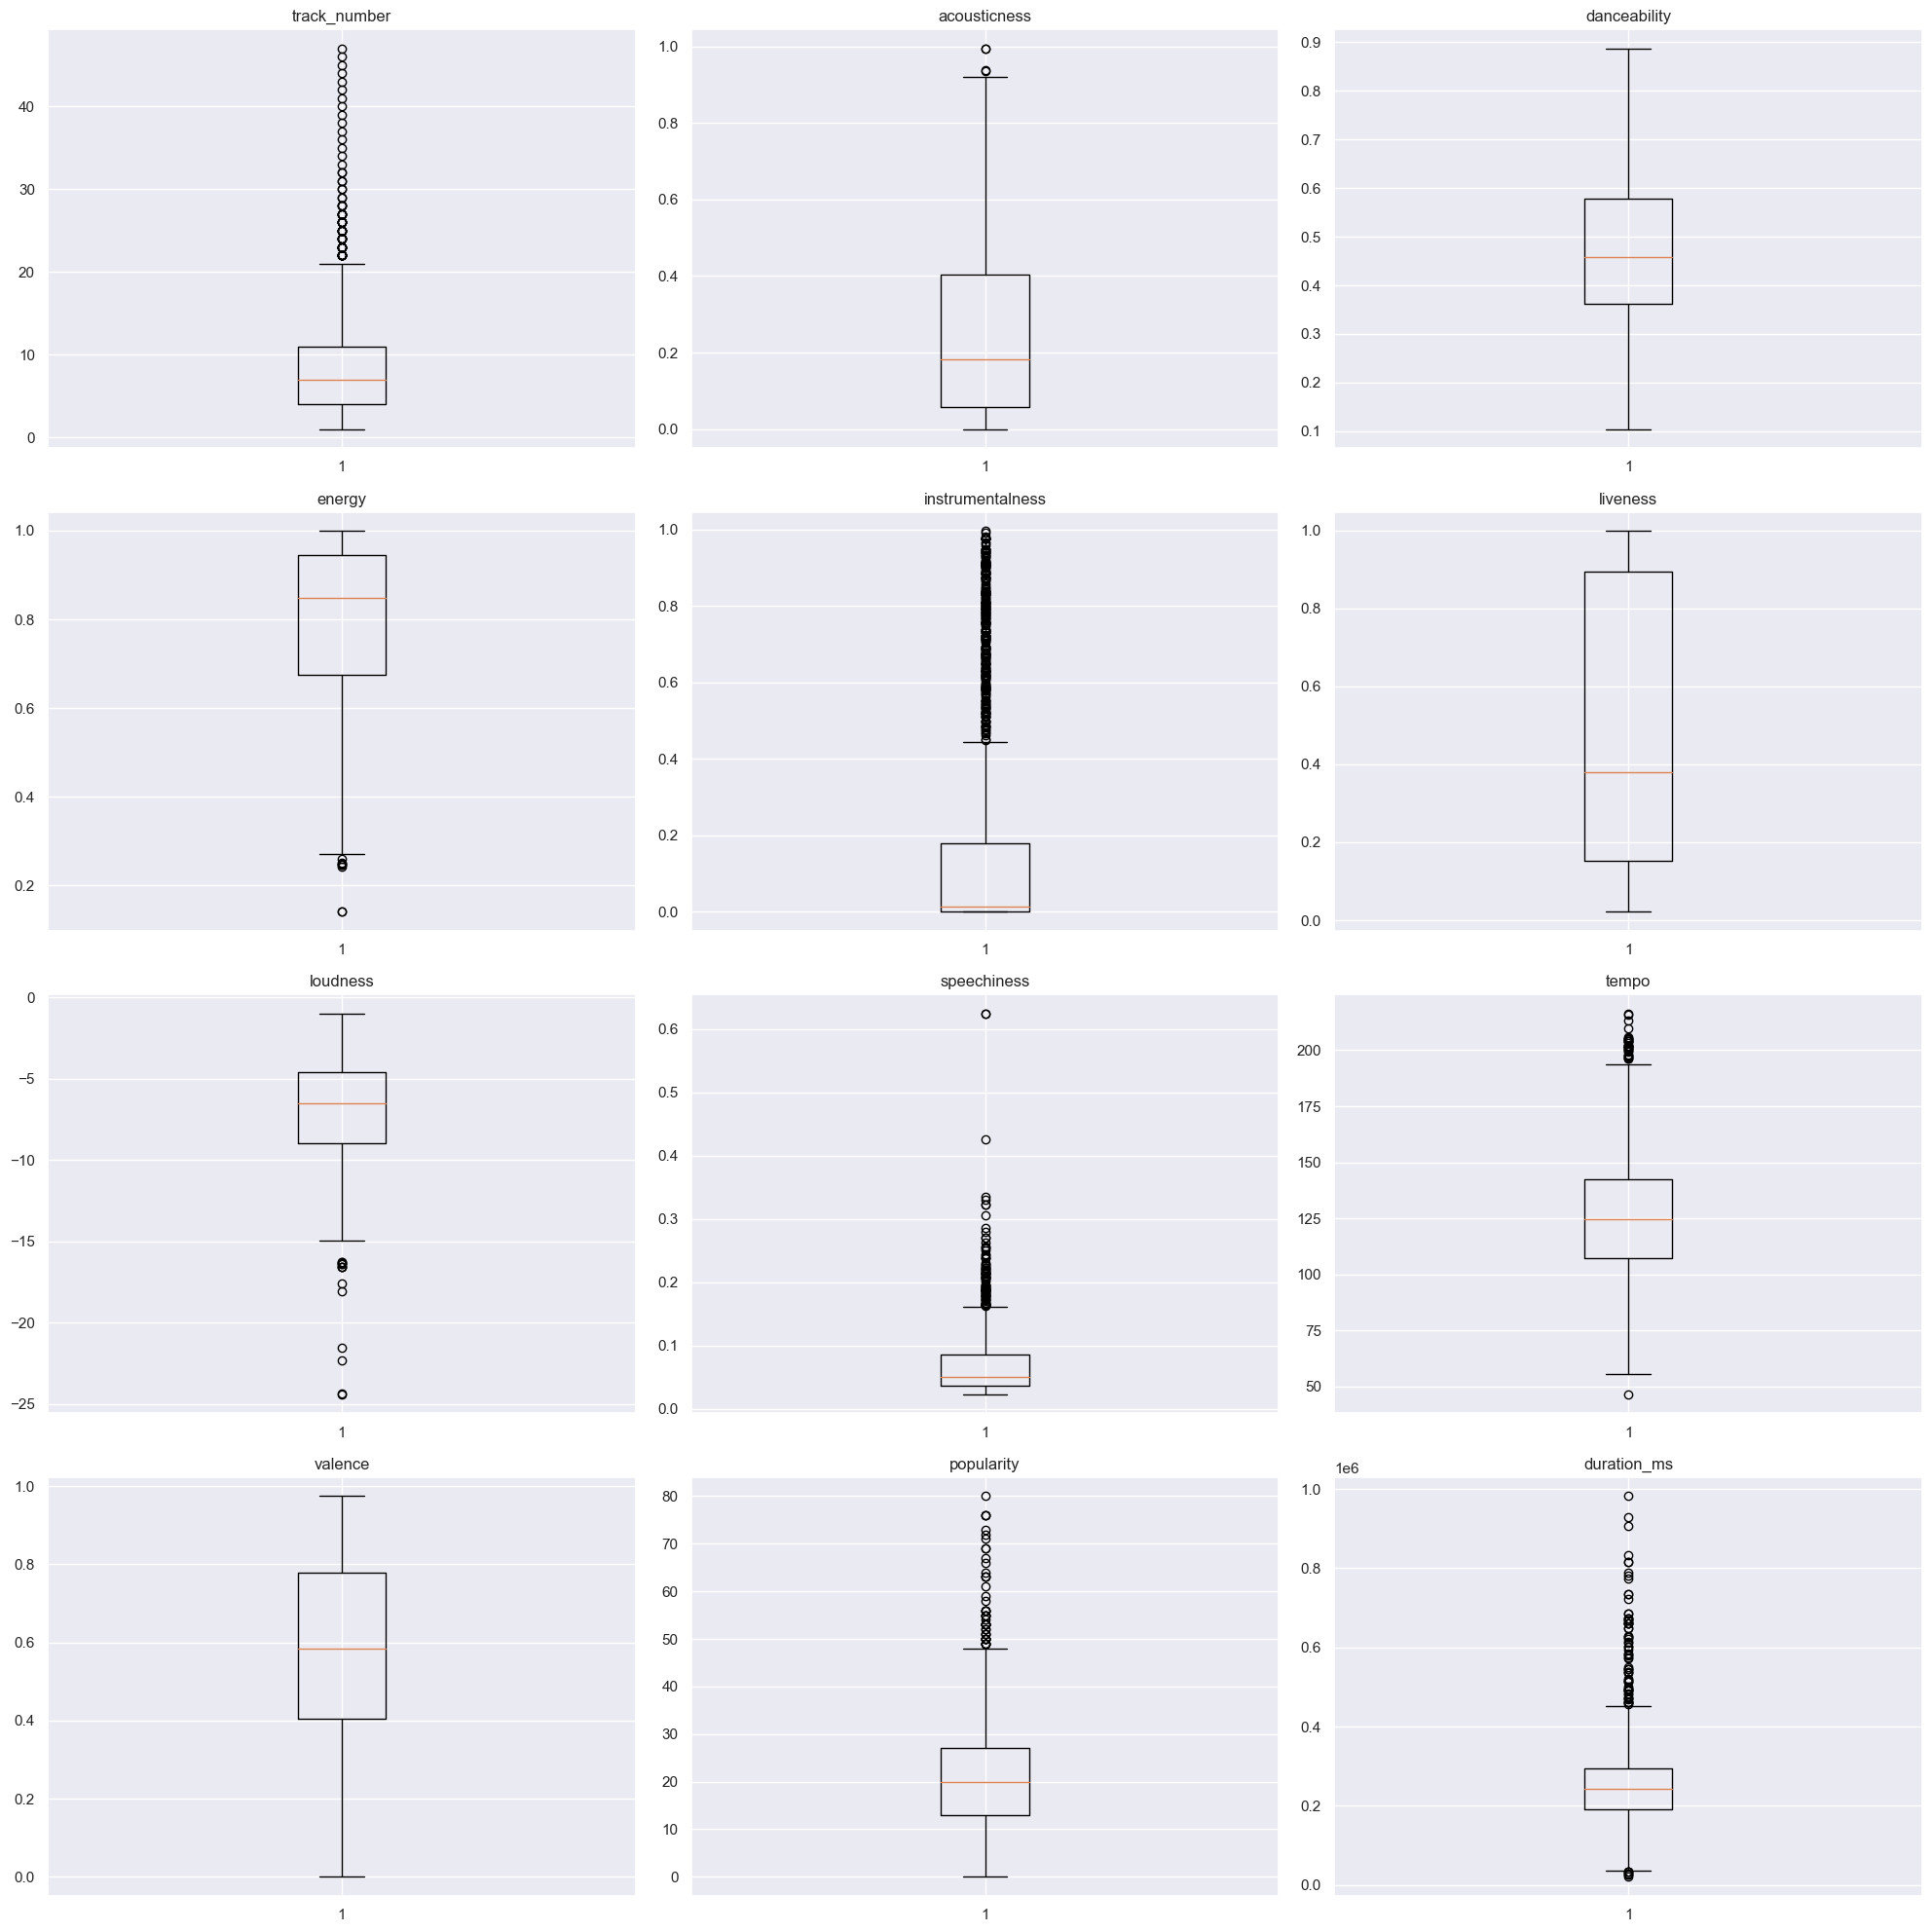

In [167]:
# Checking Outliers
def outlier_checker(coutinuous_df,fig_name):
    '''
        parameter type:positional and the given dataframe must contain numeric data
        This function gives the skewness of the given column and plot the box plot for all the column to check the outliers
    '''
    print(f'Snewness Scores:\n {continuous_df.skew(axis=0)}')
    # Ploting box plot
    plt.figure(figsize=(20,20))
    for indx,col in enumerate(continuous_df):
        plt.subplot(4,3,indx+1)
        plt.title(col)
        plt.boxplot(continuous_df[col])
        plt.savefig('Skewness')
    plt.tight_layout()
    save_plots(fig_name)

outlier_checker(continuous_df,'box plot1')

<span style="font-size:28px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Depending on your finding, clean the data for further processing.</span>

Snewness Scores:
 track_number       -0.017543
acousticness       -0.247978
danceability       -0.253348
energy             -1.058083
instrumentalness    0.731103
liveness           -0.171067
loudness            0.028898
speechiness         0.895138
tempo              -0.036787
valence            -0.652202
popularity         -0.462835
duration_ms         0.057372
dtype: float64


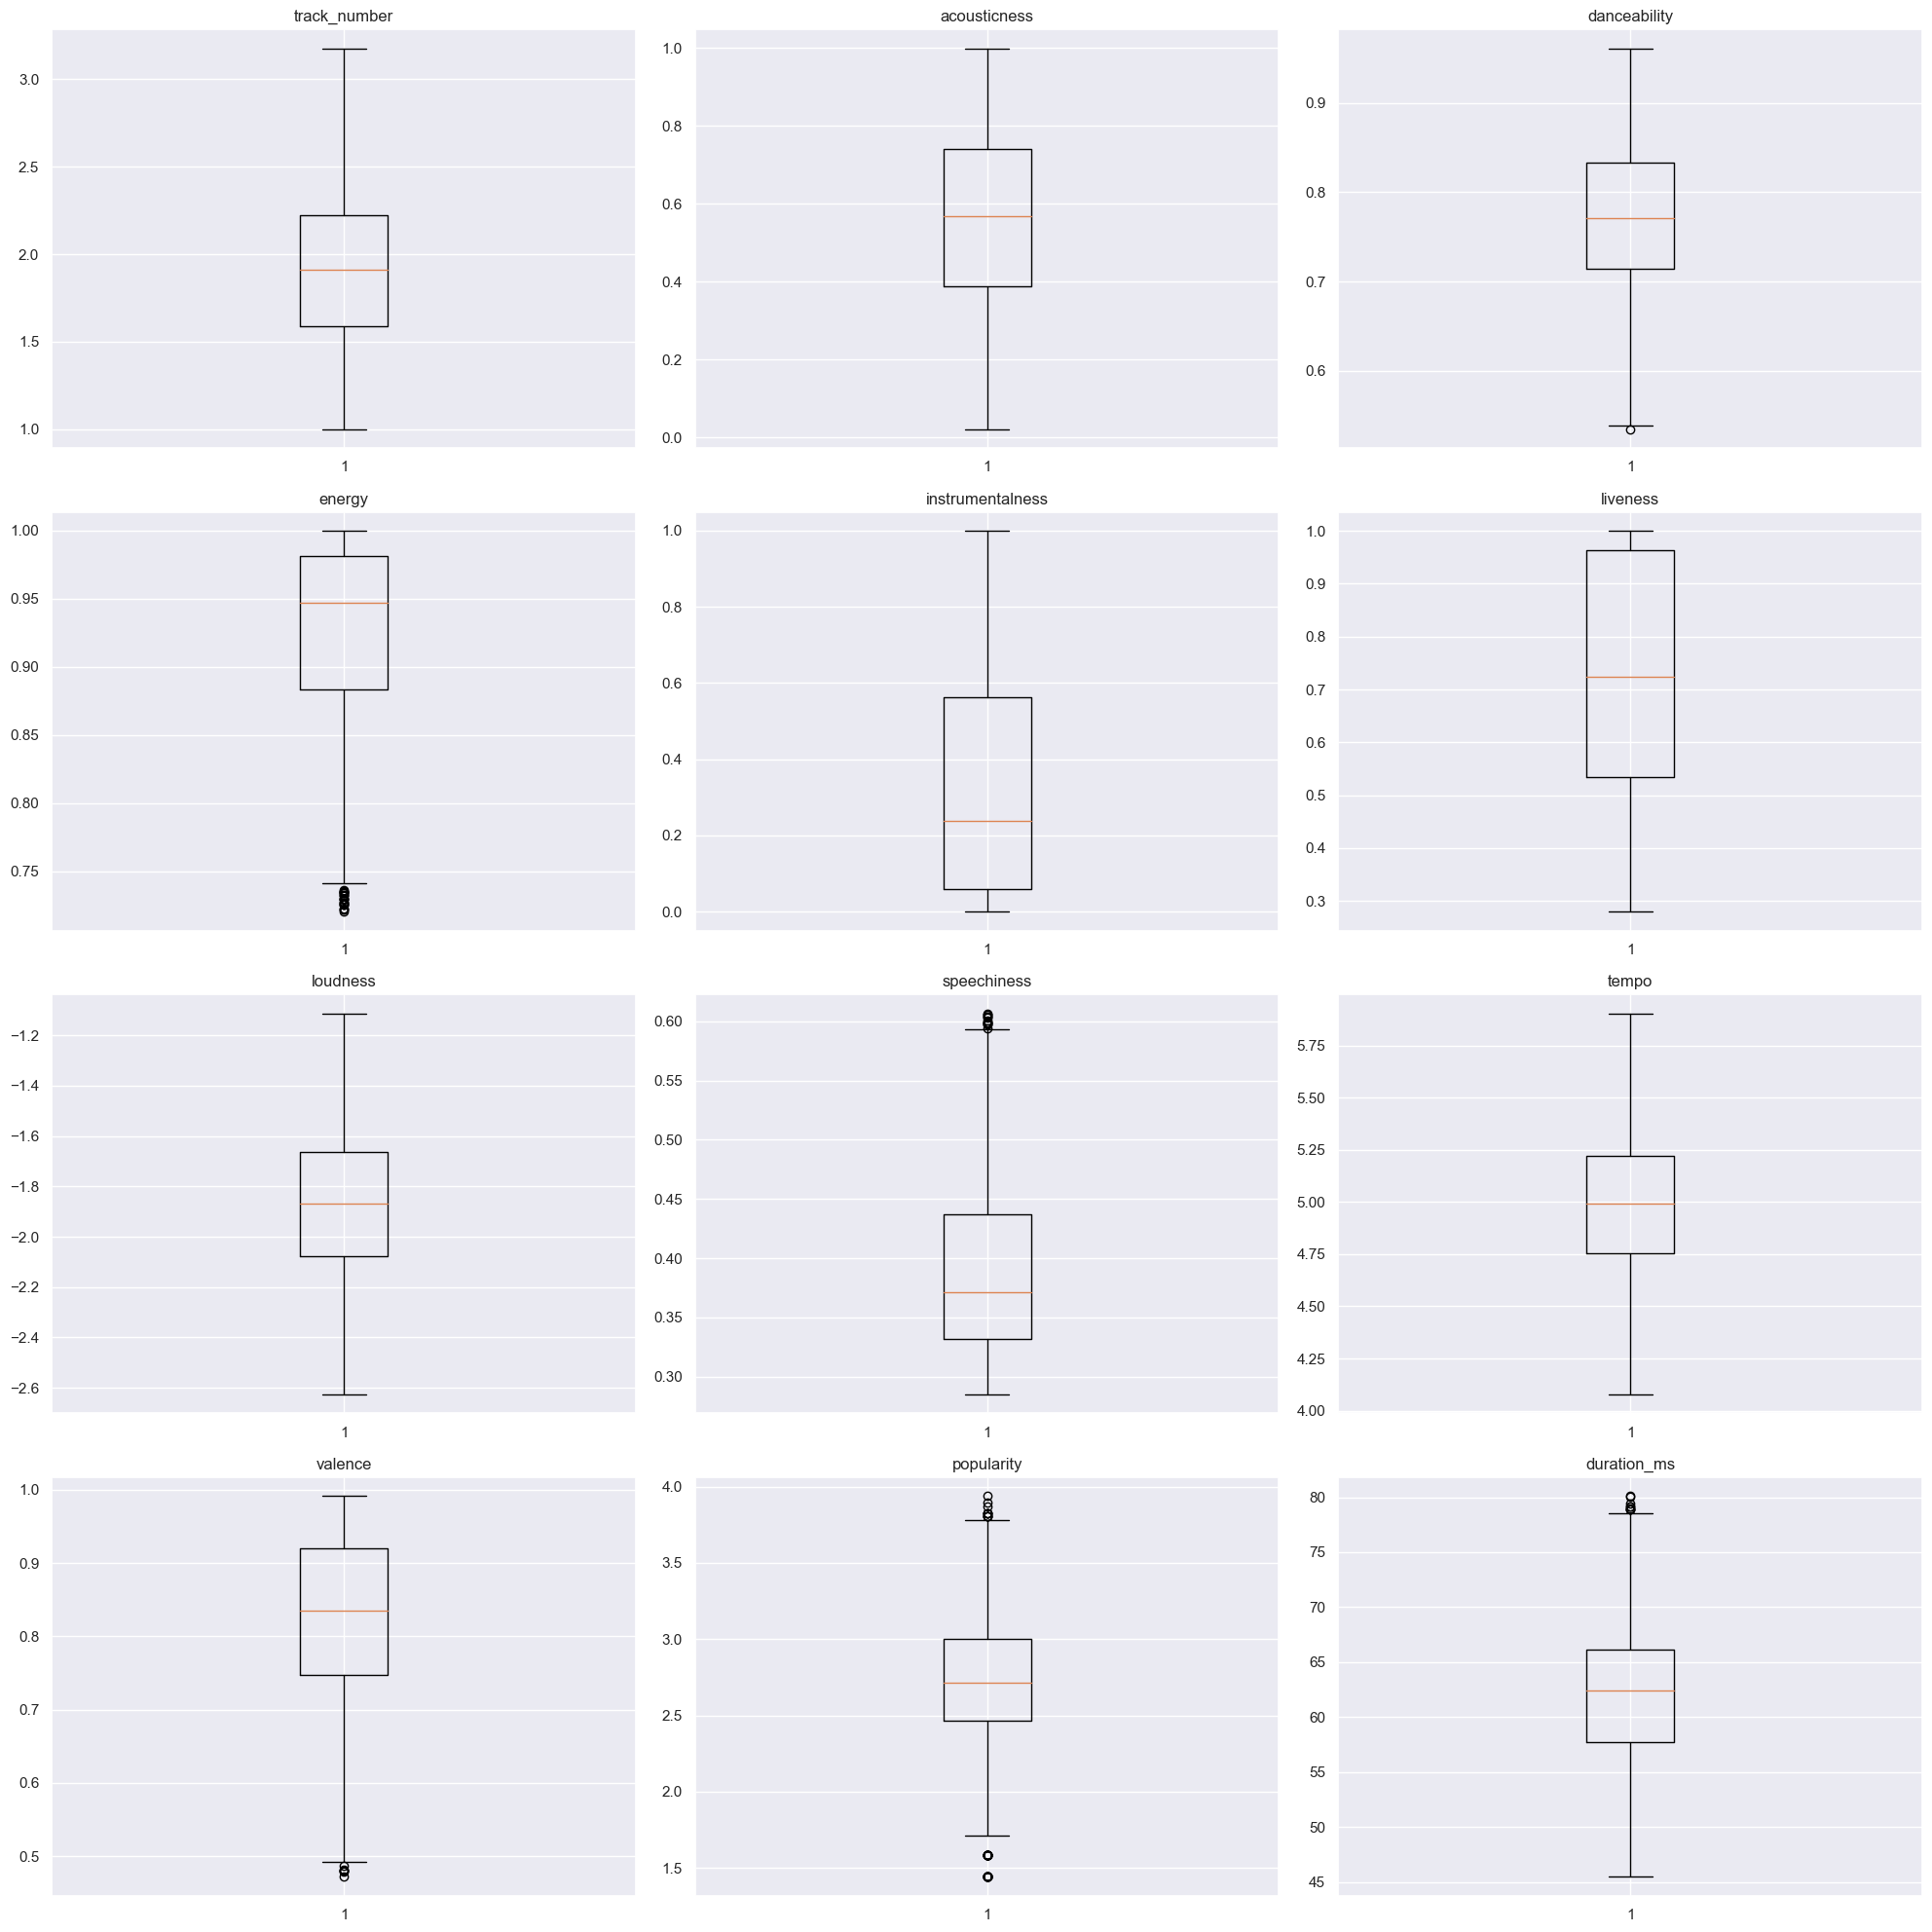

In [168]:
# Treating outliers
# Taking cube root
continuous_df=np.cbrt(continuous_df)

# I use the inter quantile range to remove the outliers
for col in continuous_df.columns:
    q1,q3=np.percentile(continuous_df[col],[25,75])
    iqr=q3-q1
    # finding the upper bound and lower bound
    upper_bound=q3+1.5*iqr
    lower_bound=q1-1.5*iqr

    # getting the outlier data points
    outliers=continuous_df[col][(continuous_df[col]>upper_bound)| (continuous_df[col]<lower_bound)]
    continuous_df.loc[outliers.index,col]=np.median(continuous_df[col])
    
    
# calling the outlier_checker function to check the data distribution again after taking cube root and replace the
# outlier datapoints with the median
outlier_checker(continuous_df,'boxplot2')

<span style="font-size:28px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Perform Exploratory Data Analysis and Feature Engineering:</span>

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Use appropriate visualizations to find out which two albums should be recommended to anyone based on the number of popular song in an album.</span>

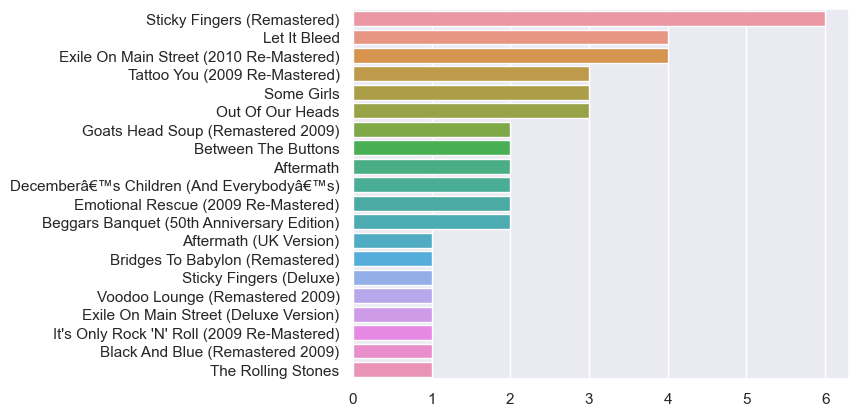

In [169]:
popularity_threshold=50
# Since the popularity rating maximum was 80 So lets take all the song that's popularity greater than 50
popular_songs=song_dat.loc[song_dat['popularity']>=popularity_threshold]

top_songs=popular_songs['album'].value_counts().sort_values(ascending=False)

sns.barplot(x=top_songs.values,y=top_songs.index)

save_plots('Popular albums')
plt.show()

### Findings
- The best two albums recommend based on the number of popular songs in the album are
- 1 Sticky Fingers (Remastered)
- 2 Let It Bleed/Exile On Main Street Re-Mastered

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Perform exploratory data analysis to dive deeper into different features of songs and identify the pattern.</span>

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Check the data distribution for numerical features.</span>

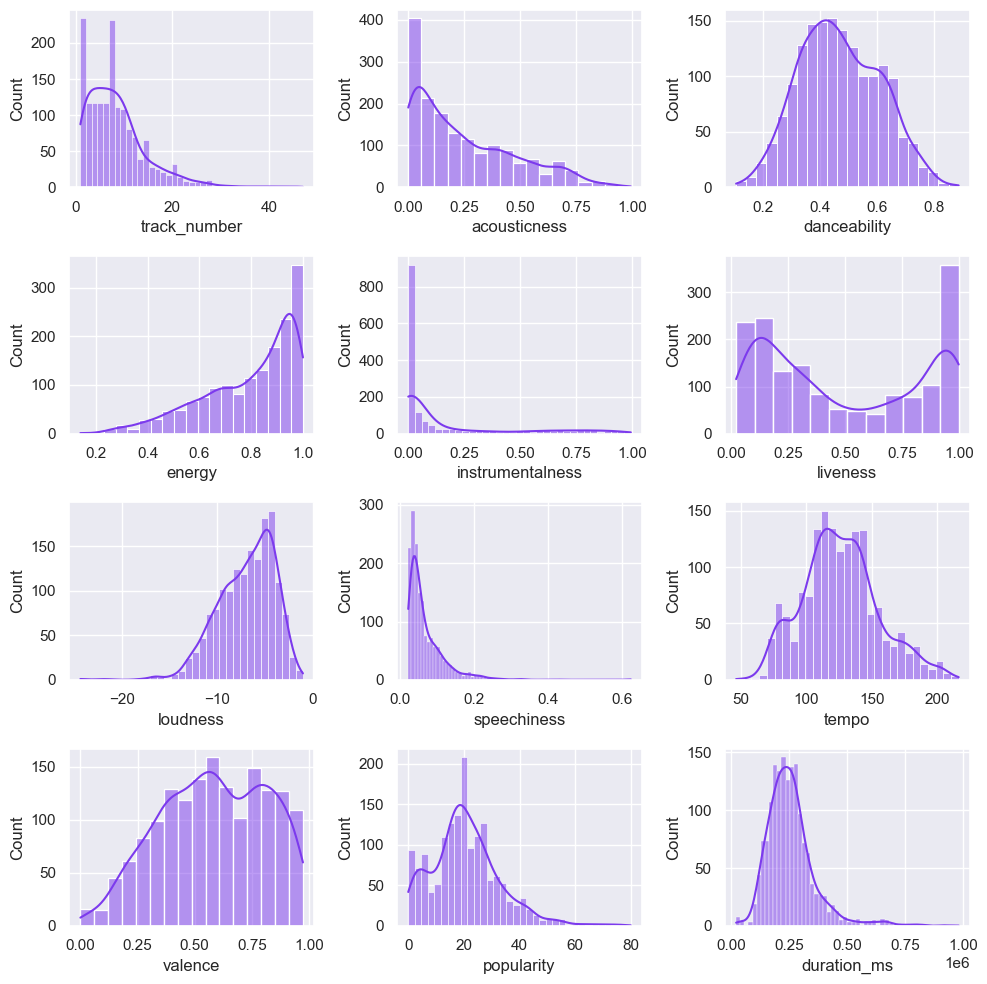

In [170]:
fig,ax=plt.subplots(4,3,figsize=(10,10))
for col,ax in zip(song_dat.select_dtypes('number').columns,ax.flatten()):
    sns.histplot(song_dat[col],kde=True,color='#7c3aed',ax=ax)
#     sns.histplot(song_dat[col],kde=True,color='#16a34a',ax=ax)
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- There was some feature who have skewed data distribution

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Check the data distribution for release date.</span>

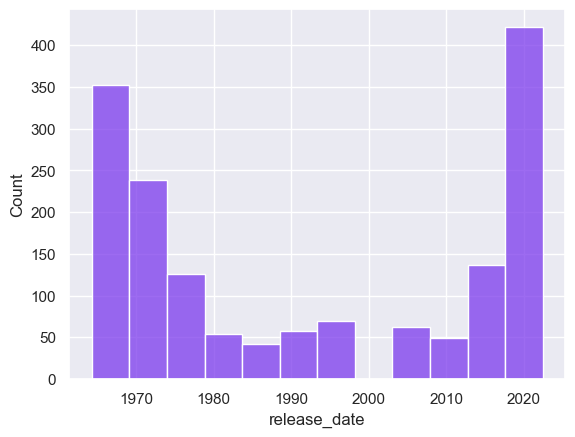

In [171]:
sns.histplot(song_dat['release_date'],color='#7c3aed')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- There are number of song release in the year 1970 and 2020
- Years 2000 have lease number of release song. We can dig deeper to check why there is less release in song in the year 2000 what happen to this year.

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Checking the numbers of unique value for the columns.</span>

In [172]:
print(f'Unique values: \n{song_dat.nunique().sort_values()}')

Unique values: 
track_number          47
release_date          57
popularity            69
album                 90
energy               511
danceability         518
speechiness          655
valence              701
liveness             757
acousticness         933
name                 954
instrumentalness    1134
duration_ms         1320
loudness            1329
tempo               1424
uri                 1610
id                  1610
dtype: int64


<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- We notice that some columns have less number or unique value and some are high. Less number of unique values indicates the data is categorical in nature.
- Even there are song that the same name, it may be because a song can have different version and one can cover the song

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Describing the dataset.</span>

In [173]:
song_dat.describe()

track_number  acousticness  danceability       energy  \
count   1610.000000   1610.000000   1610.000000  1610.000000   
mean       8.613665      0.250475      0.468860     0.792352   
std        6.560220      0.227397      0.141775     0.179886   
min        1.000000      0.000009      0.104000     0.141000   
25%        4.000000      0.058350      0.362250     0.674000   
50%        7.000000      0.183000      0.458000     0.848500   
75%       11.000000      0.403750      0.578000     0.945000   
max       47.000000      0.994000      0.887000     0.999000   

       instrumentalness    liveness     loudness  speechiness        tempo  \
count       1610.000000  1610.00000  1610.000000  1610.000000  1610.000000   
mean           0.164170     0.49173    -6.971615     0.069512   126.082033   
std            0.276249     0.34910     2.994003     0.051631    29.233483   
min            0.000000     0.02190   -24.408000     0.023200    46.525000   
25%            0.000219     0.15300    -8.982500     0.036500   107.390750   
50%            0.013750     0.37950    -6.523000     0.051200   124.404500   
75%            0.179000     0.89375    -4.608750     0.086600   142.355750   
max            0.996000     0.99800    -1.014000     0.624000   216.304000   

           valence   popularity    duration_ms  
count  1610.000000  1610.000000    1610.000000  
mean      0.582165    20.788199  257736.488199  
std       0.231253    12.426859  108333.474920  
min       0.000000     0.000000   21000.000000  
25%       0.404250    13.000000  190613.000000  
50%       0.583000    20.000000  243093.000000  
75%       0.778000    27.000000  295319.750000  
max       0.974000    80.000000  981866.000000

In [174]:
song_dat.describe(include='O')

name                       album  \
count                 1610                        1610   
unique                 954                          90   
top     Brown Sugar - Live  Voodoo Lounge Uncut (Live)   
freq                    16                          56   

                            id                                   uri  
count                     1610                                  1610  
unique                    1610                                  1610  
top     2IEkywLJ4ykbhi1yRQvmsT  spotify:track:2IEkywLJ4ykbhi1yRQvmsT  
freq                         1                                     1

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Show the data distribution for all the columns for the each years.</span>

In [175]:
# Find the years
years=song_dat['release_date'].dt.year.unique()

# Flip to arrange in increasing order
years=np.flip(years)

# Creating an array of dataframe based on the year as all the value that have the same particular years are in the same arary position
years_df=[]
for year in years:
    years_df.append(song_dat[song_dat['release_date'].dt.year==year])

In [29]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
for indx,df_ in enumerate(years):
    print(years[indx],"Data")
    years_df[indx].hist(figsize=(25,25))
    save_plots(str(years[indx]))
    plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">In the below I plot the numerical features for each year. From this we can gain insight how this change over time</span>

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Acousticness Data for all the year.</span>

In [177]:
df=song_dat.copy()

In [18]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['acousticness']
    df_.hist()
save_plots('Acousticness all years')

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- We see that acousticness is change over the year it become higher years after years

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Danceability Data for all the year.</span>

In [20]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['danceability']
    df_.hist()
save_plots('Danceability for all the year')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- We see that danceability does not much change over time, But some years have the danceability lesser and some are higher like 2022 have most of the song are danceable and years like 1971 have less danceable.

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Energy Data for all the year.</span>

In [21]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['energy']
    plt.savefig('Energy')
    df_.hist()
save_plots('Enerty data for all the years')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- In some years enery less very less and some years have high energy.

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Instrumentalness Data for all the year..</span>

In [22]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['instrumentalness']
    df_.hist()
save_plots('Instrumentalness data for all the years')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- There are some years which instrumentalness are very less

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Liveness Data for all the year.</span>

In [23]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['liveness']
    df_.hist()
save_plots('Liveness data for all the year')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- We can see some pattern like liveness in increase over years

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Speechiness Data for all the year.</span>

In [24]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['speechiness']
    df_.hist()
save_plots('Speechiness data for all the year')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Speechness not much change over the time it is like same for most the years

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Tempo Data for all the year.</span>

In [25]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['tempo']
    df_.hist()
save_plots('Tempo data for all the years')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Not much change in tempo for the years, but some years have less tempo and some have more and balence

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Valence Data for all the year.</span>

In [26]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['valence']
    df_.hist()
save_plots('Valence data for all the years')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Valence is somewhat like increasing over time

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Popularity Data for all the year.</span>

In [27]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['popularity']
    df_.hist()
save_plots('Popularity Data for all the years')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Some years have less number of popular song and some have high number of popular song.

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Duration Data for all the year.</span>

In [28]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
plt.figure(figsize=(20,20))
for i in enumerate(years):
    plt.subplot(5,7,i[0]+1)
    plt.title(i[1])
    df_=df.loc[df['release_date'].dt.year==i[1]]['duration_ms']
    df_.hist()
save_plots('Duration data for all the years')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Most of the duration of the songs over the years are same, some years have more numbre of durable song and some have less

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Perform exploratory data analysis to dive deeper into different features of songs and identify the pattern.</span>

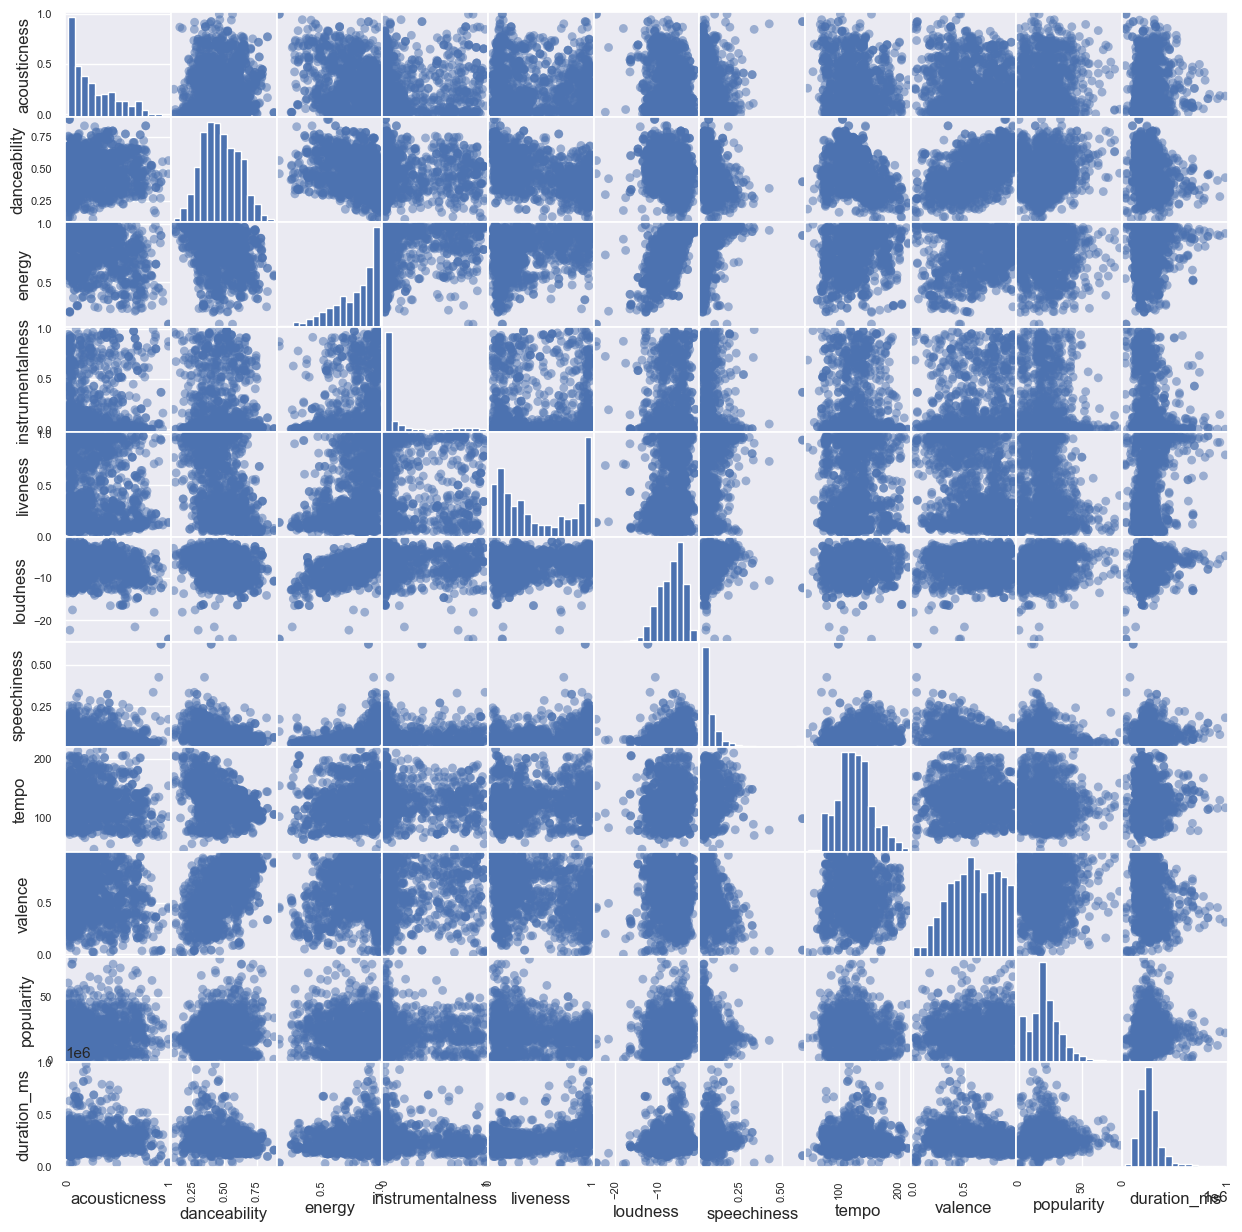

In [188]:
# audio features
# aud = ['valence', 'energy', 'speechiness','tempo']
X_aud = song_dat.iloc[:,6:]
cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X_aud, marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(15,15), cmap=cmap)
save_plots('Features relationship')

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Ploting heatmap to check how the other features are correlated with the popularity.</span>

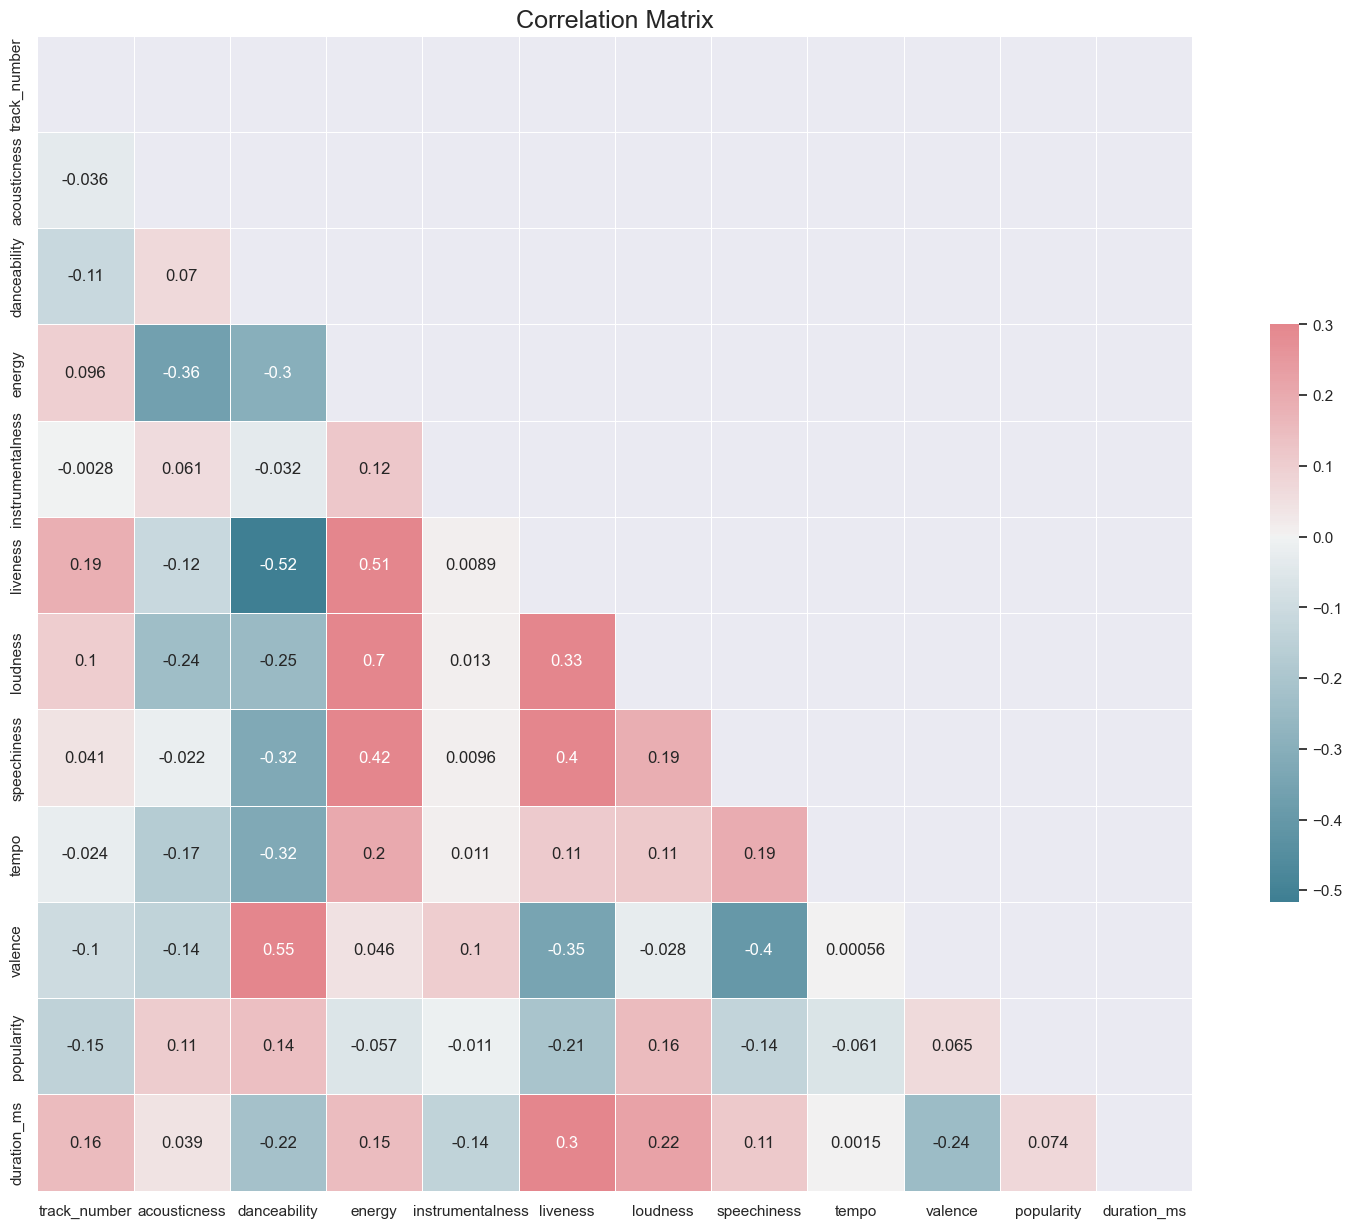

In [189]:
corr = song_dat.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True)
save_plots('Heatmap 1')
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Reduced the features to select the most 10 coorelated features with the popularity.</span>

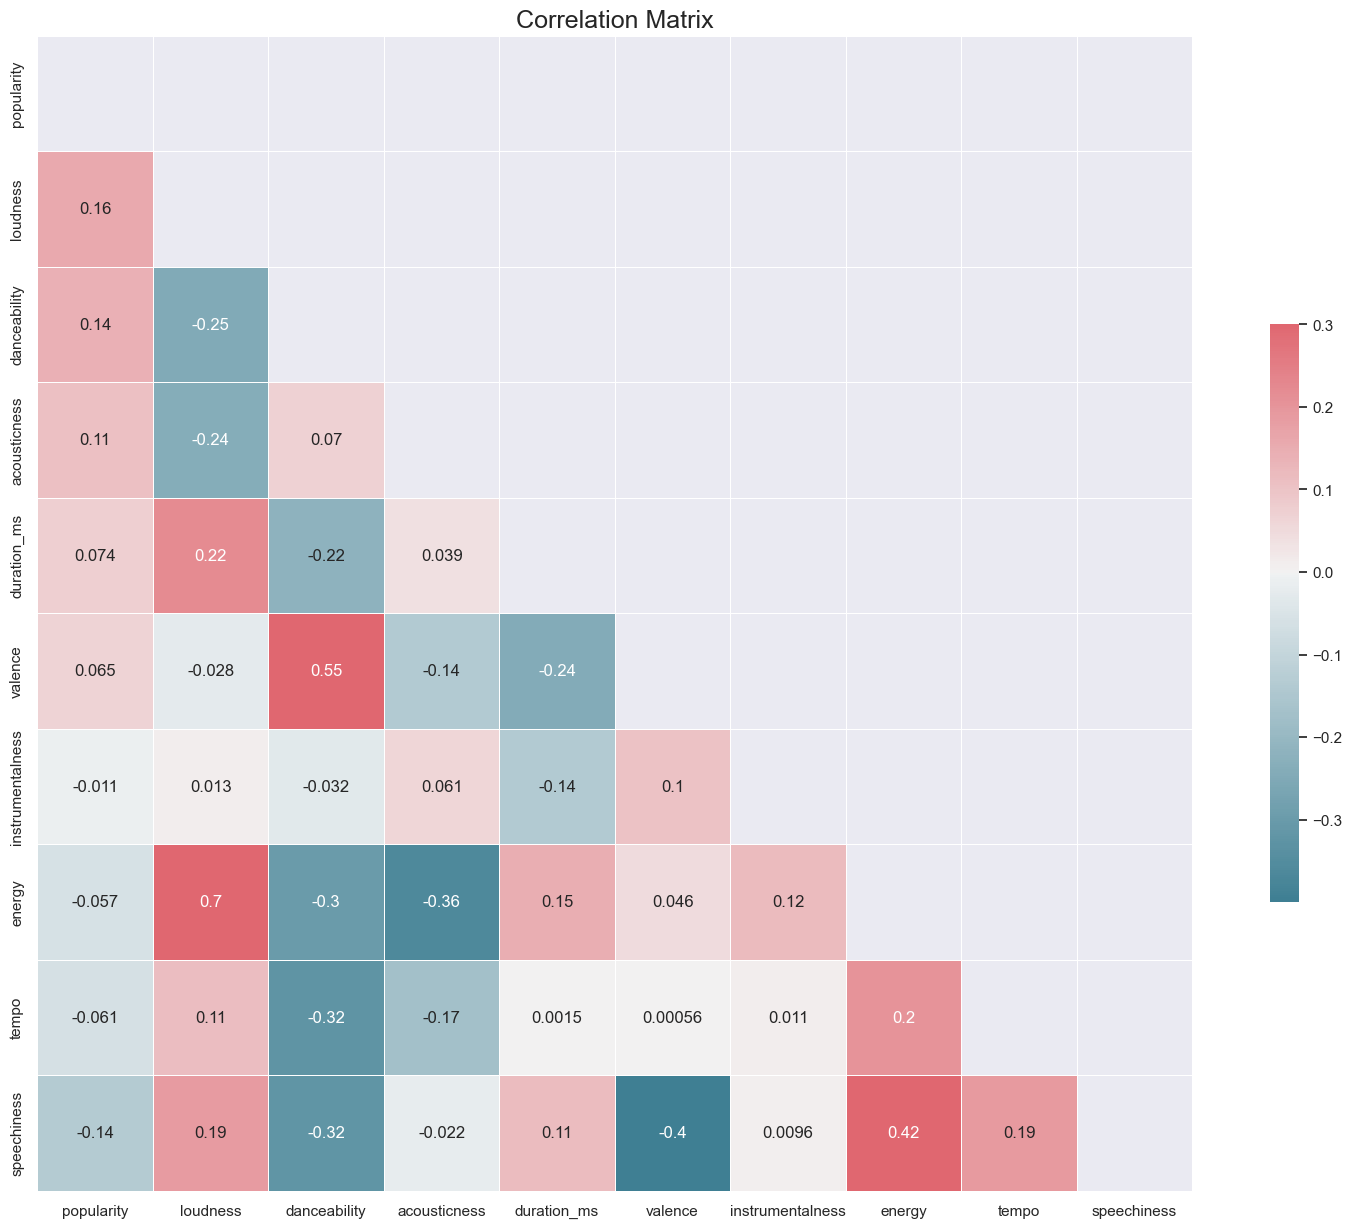

In [190]:
# number of variables to be selected
k = 10

# finding the most correlated variables
cols = song_dat.corr().nlargest(k, 'popularity')['popularity'].index
corr=song_dat[cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True)
save_plots('Heatmap 2')
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Negative coorelation between popularity and speechiness
- Negative coorelation between tempo and popularity
- Negative coorelation between energy and popularity
- Positive coorelatoin between danceability and popularity
- Positive coorelaton between loudness and popularity
- Positive coorelaton between acousticness and popularity

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Discover how a song's popularity relates to various factors and how this has changed over time.</span>

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Yearly data to check what features in which are more coolreated to the popularity. And how things change over time.</span>

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between acousticness and popularity over time.</span>

In [41]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='acousticness',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('acousticness vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between track_number and popularity over time.</span>

In [40]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='track_number',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('track_number vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between danceability and popularity over time.</span>

In [39]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='danceability',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('daceability vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between energy and popularity over time.</span>

In [38]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='energy',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('energy vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between instrumentalness and popularity over time.</span>

In [37]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='instrumentalness',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('instrumetalness vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between liveness and popularity over time.</span>

In [36]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='liveness',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('liveness vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between loudness and popularity over time.</span>

In [35]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='loudness',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('loudness vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between speechiness and popularity over time.</span>

In [34]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='speechiness',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('speechiness vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between tempo and popularity over time.</span>

In [33]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='tempo',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('tempo vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation between valence and popularity over time.</span>

In [32]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='valence',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('valence vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Relation duration_ms and popularity over time.</span>

In [31]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(5,7,figsize=(20,20))
for year,ax in zip(years,ax.flatten()):
    tmp_df=song_dat[song_dat['release_date'].dt.year==year]
    sns.scatterplot(data=tmp_df,x='duration_ms',y='popularity',ax=ax)
    ax.set_title(year,fontsize=20)
save_plots('duration_ms vs popularity')
plt.tight_layout()
plt.show()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- We can see that there is a change in relationship between popularity and different feataures over time.

In [30]:
# To view this plot please rerurn this notebook,I can't plot this due to size limitation on project upload.
fig,ax=plt.subplots(12,3,figsize=(10,35))
for indx,year_ax in enumerate(zip(np.flip(years),ax.flatten())):
    cols = years_df[indx].corr().nlargest(4, 'popularity')['popularity'].index
    cm = np.corrcoef(years_df[indx][cols].values.T)
#     plotting the heatmap
    year_ax[1].set_title(year_ax[0])
    sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values,ax=year_ax[1])
plt.tight_layout()
plt.show()
save_plots('Heatmap for the all the years')    

In [203]:
print("Features That are coorelated with the popularity for different years")
print("--------------------------------------------------------------------")
corelation_arr=[]
for indx,year in enumerate(np.flip(years)):
    cols = years_df[indx].corr().nlargest(4, 'popularity')['popularity'].index
    cm = np.corrcoef(years_df[indx][cols].values.T)
    for col in cols[1:]:
        corelation_arr.append(col)
    print(year,cols.values[1:])

Features That are coorelated with the popularity for different years
--------------------------------------------------------------------
2022 ['speechiness' 'tempo' 'duration_ms']
2021 ['duration_ms' 'acousticness' 'track_number']
2020 ['danceability' 'valence' 'acousticness']
2019 ['loudness' 'liveness' 'acousticness']
2018 ['speechiness' 'loudness' 'duration_ms']
2017 ['loudness' 'duration_ms' 'acousticness']
2016 ['loudness' 'instrumentalness' 'danceability']
2012 ['danceability' 'acousticness' 'valence']
2011 ['danceability' 'acousticness' 'liveness']
2005 ['loudness' 'tempo' 'speechiness']
2004 ['loudness' 'energy' 'danceability']
1997 ['loudness' 'acousticness' 'duration_ms']
1995 ['loudness' 'energy' 'speechiness']
1994 ['duration_ms' 'danceability' 'valence']
1991 ['loudness' 'duration_ms' 'danceability']
1989 ['loudness' 'danceability' 'energy']
1986 ['loudness' 'energy' 'duration_ms']
1983 ['speechiness' 'energy' 'loudness']
1982 ['danceability' 'valence' 'energy']
1981 ['lo

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- We see that the populary of a song for different year is due to dirrerent reasons, som have slightly similar reason

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Check the featuers that are highly related to popularity.</span>

In [204]:
df=pd.DataFrame(corelation_arr)
df.value_counts()

loudness            23
danceability        14
duration_ms         14
energy              11
acousticness        10
speechiness          8
valence              8
liveness             7
instrumentalness     5
tempo                3
track_number         2
dtype: int64

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Overall loudness is more related to the popularity of a song

<span style="font-size:15px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Some of the most important features to make the song popular.</span>
- Loudness of the song is the most import features to become popular in the sense that a song must have some deep voice to become popular and touch the hearth of the listener.
- Duration of the song is also important feature to become popular as if as song was only 10 second long no one's gonna like it
- Danceability is aslo an important as if the song is good at dancing most of the people like the song , even though they cannot dance as they are admire by the beautiful dance performed by the dancers or enthusiast
- Energy is also important as a song which give energy is mostly want by everyone despite of age

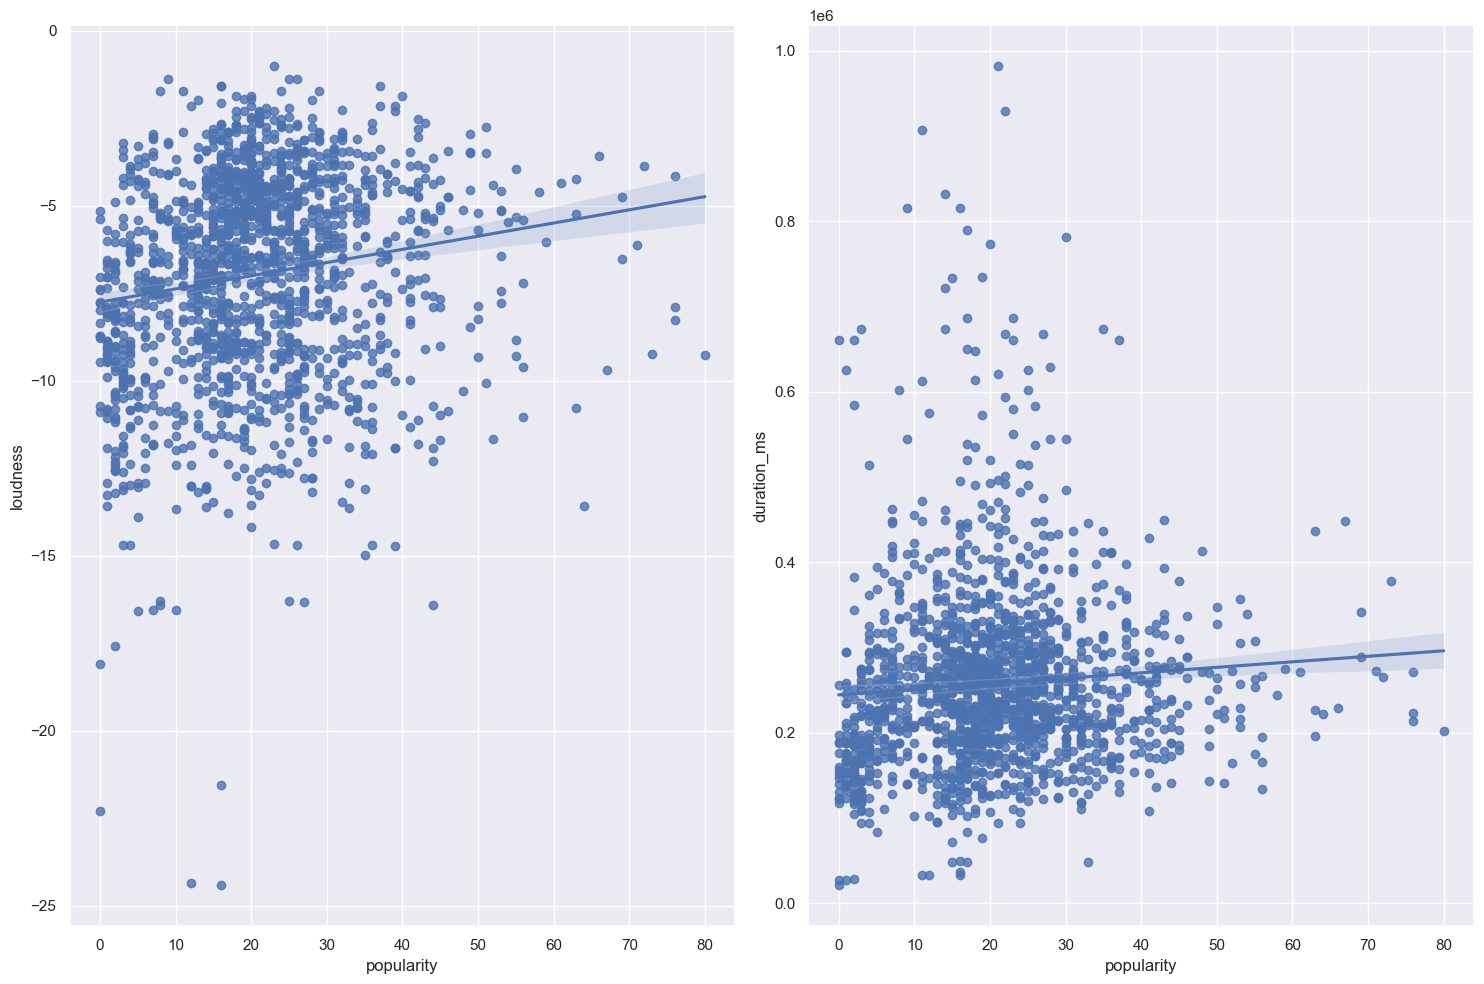

In [205]:
# scatter plots with linear regression line
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15,10));
sns.regplot(x=song_dat['popularity'], y=song_dat['loudness'],ax=ax1);
sns.regplot(x=song_dat['popularity'], y=song_dat['duration_ms'],ax=ax2);
plt.tight_layout()
save_plots('Scatter1')

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Most popular song have loudness in the range of 0,-10 there are some outlier present in it
- Most of the popular song have duration in the range of 1-4, high popular song have duration near 2

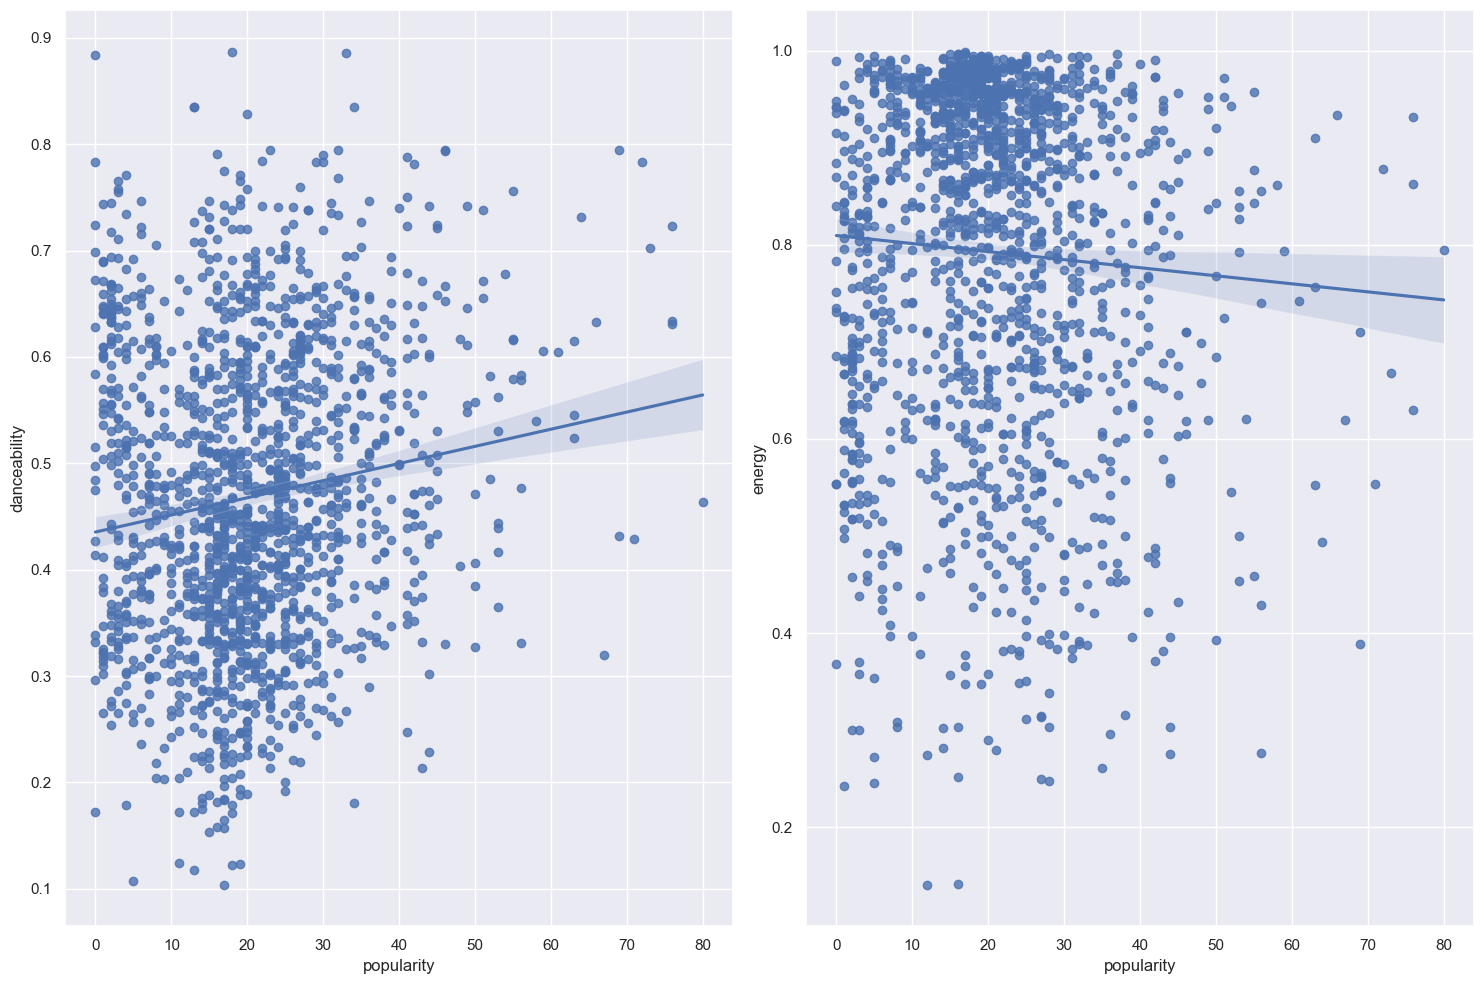

In [206]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15,10));
sns.regplot(x=song_dat['popularity'], y=song_dat['danceability'],ax=ax1);
sns.regplot(x=song_dat['popularity'], y=song_dat['energy'],ax=ax2);
plt.tight_layout()
save_plots('Scatter2')

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Danceability vary a lot and most popular song are less danceable
- Enery vary as well

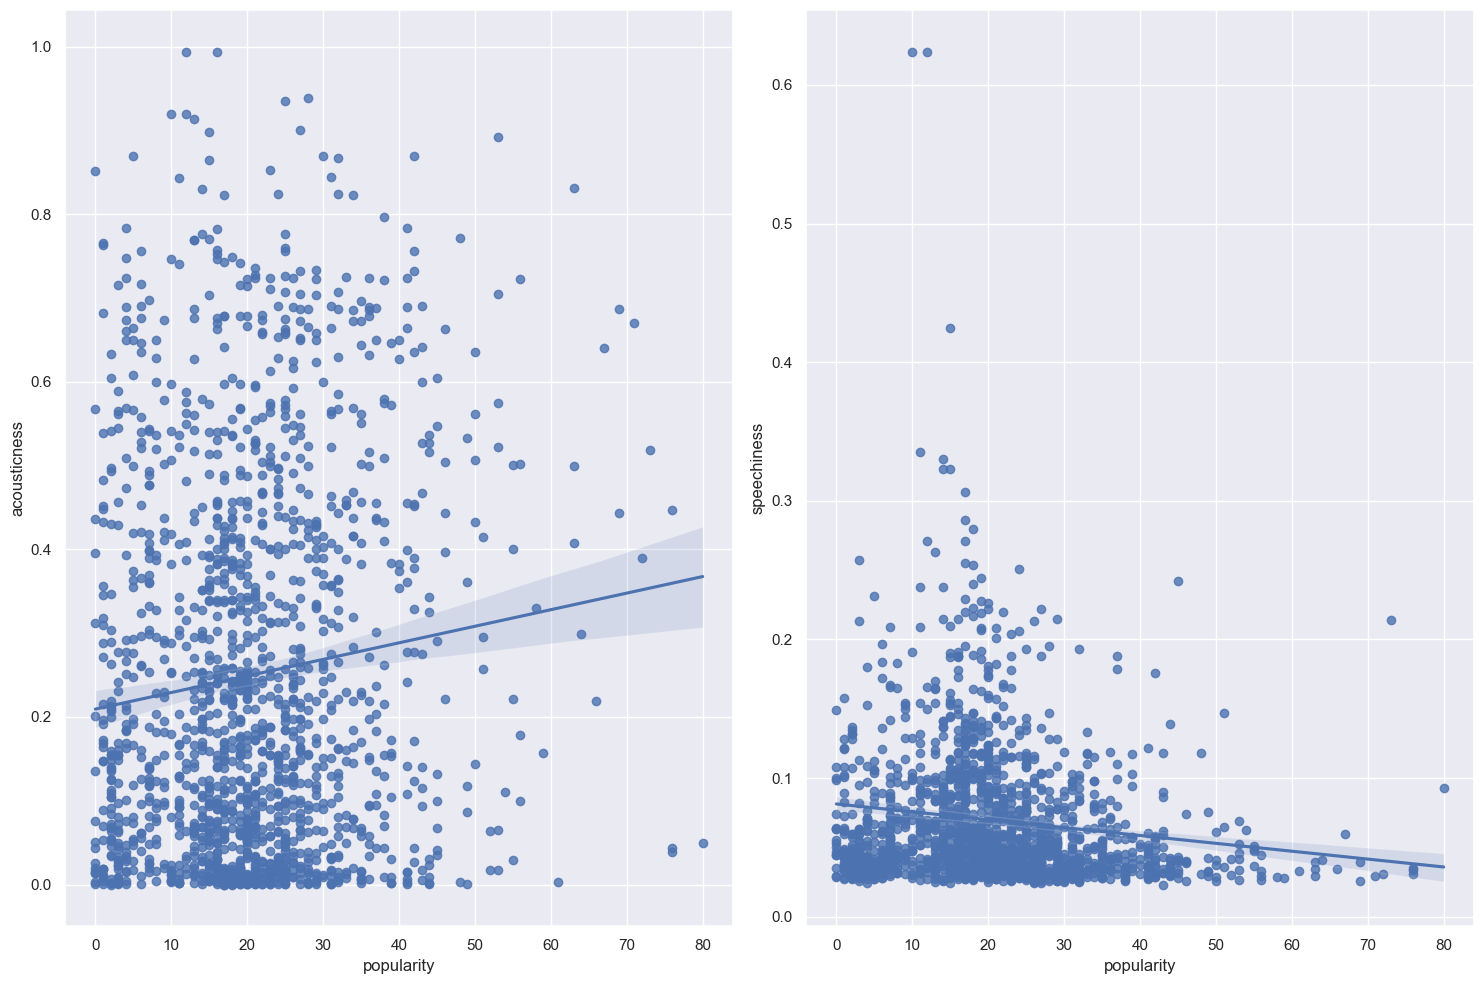

In [207]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15,10));
sns.regplot(x=song_dat['popularity'], y=song_dat['acousticness'],ax=ax1);
sns.regplot(x=song_dat['popularity'], y=song_dat['speechiness'],ax=ax2);
plt.tight_layout()
save_plots('Scatter3')

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- Acousticness vary as lot but speechiness does not vary a lot
- Like when popularity increase speechiness decrease

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Comment on the importance of dimensionality reduction techniques, share your ideas and explain your observations.</span>

As the number of features in our data increases, traditional analysis methods suffer from the "curse of dimensionality." This means models require more data, become computationally expensive, and are prone to overfitting. Dimensionality reduction alleviates this by condensing the information into a lower-dimensional space while preserving the essential patterns.

Pca is mostly commonly used dimensionality reduction technique to reduce the number of features when we have a dataset with large number of features.

<span style="font-size:28px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Perform Cluster Analysis:</span>

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Identify the right number of clusters.</span>

In [208]:
model_data=song_dat.copy()

In [209]:
def preprocessing_data(data,drop_cols,scale_type=StandardScaler,pca_n_component=0.95):
    '''
    def: function to preprocess the data which include drop the unwanted column,
    standardize the data and perform pca to give the final result. It return two value a dataframe and the array
    of the pca result.
    
    args:
        arg1:data-The dataframe to work with
        arg2:drop_cols-The column to drop from the data
        arg3:scale_type-The standardization type
        arg4:pca_n_component-The number of component of the pca
    '''
    # Drop the unwanted columns
    X=data.drop(drop_cols,axis=1)
    
    # Standardization the data
    scaler=scale_type()
    scale_song_df=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
    scale_song=scaler.fit_transform(X)
    
    # Performing PCA
    pca=PCA(n_components=pca_n_component)
    result_arr=pca.fit_transform(scale_song)
    
    # Find the number of columns
    n_cols=result_arr.shape[1]
    
    # Generating the column name for the PCA dataframe
    comp_name=['Component '+str(x) for x in range(n_cols)] 
    result_df=pd.DataFrame(result_arr,columns=comp_name)
    return result_df,result_arr

In [210]:
drop_cols=['track_number','name','album','release_date','id','uri']

In [211]:
model_pca_df,model_pca_arr=preprocessing_data(model_data,drop_cols,MinMaxScaler,2)

In [212]:
model_pca_df.to_csv(CSV_PATH+'/model_pca.csv')

In [213]:
model_pca_df.head()

Component 0  Component 1
0    -0.562865     0.560630
1    -0.566803    -0.032554
2    -0.553333     0.113999
3    -0.555718    -0.320689
4    -0.622233    -0.226714

In [214]:
model_pca_arr[:2]

array([[-0.56286482,  0.56063   ],
       [-0.56680332, -0.03255373]])

In [215]:
# Check the number of right cluster using Elbow graph
def find_num_cluster(df):
    wcss={}

    for i in range(1,15):
        kmeans=KMeans(n_clusters=i,init='k-means++',random_state=1)
        kmeans.fit(df)
        wcss[i]=kmeans.inertia_

    plt.plot(wcss.keys(),wcss.values(),'gs-')
    plt.xlabel('Values of K')
    plt.ylabel('WCSS')
    save_plots('Elbow graph')
    plt.show()

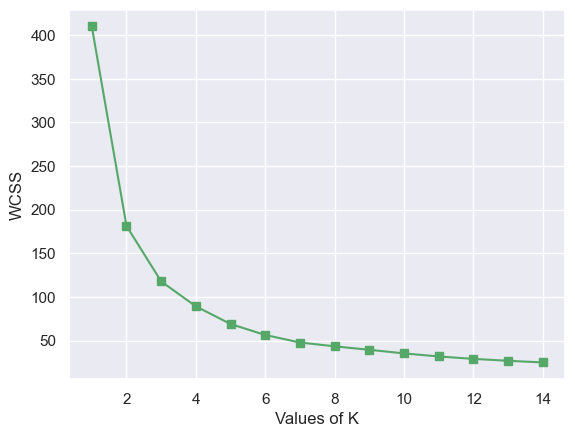

<Figure size 640x480 with 0 Axes>

In [216]:
# scale_song_df,scale_song_arr=preprocessing_data(song_dat)
find_num_cluster(model_pca_df)
plt.show()
save_plots('Elbow K Means')

In [217]:
# cross-validation: find optimal number of clusters k by mean silouette score
scores = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=7)
    kmeans.fit(model_pca_df)
    score = silhouette_score(model_pca_df, kmeans.labels_, metric='euclidean')
    print(k, score)

2 0.5095438173403372
3 0.5113451870633491
4 0.49105937082912654
5 0.4374107406900147
6 0.41321312699116136
7 0.39777664558407116
8 0.3644920753129331
9 0.36840066341454586
10 0.36908696351747317
11 0.37088233164556467
12 0.3656790740713023
13 0.3622239827134698
14 0.3659029265879628


In [218]:
# determine best clustering solution by mean silhouette score
silhouette_score(model_pca_df, kmeans.labels_, metric='euclidean')

0.3659029265879628

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- From the above Elbow graph and silhouetee score the right number of cluster is 8. So I perform K means with 8 clusters

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Use appropriate clustering algorithm.</span>

In [219]:
# Train the model
kmeans=KMeans(n_clusters = 8, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 40)
y_kmeans=kmeans.fit_predict(model_pca_arr)

In [220]:
y_kmeans

array([2, 1, 1, ..., 0, 5, 0])

In [221]:
def plot_cluster_3d(df,model,y_kmeans,num_cluster):
#     colors=['red','blue','green','magenta','gray','purple','orange']
    colors=['#FF69B4','#FFD700','#FFA500','#FF8C00','#BA55D3','#800080','#4B0082','#87CEEB','#0000FF','#000080']
    # Visualizing clusters
    fig,ax=plt.subplots(figsize=(14,11))
    ax=fig.add_subplot(111,projection='3d')
    
    for i in range(num_cluster-1):
        plt.scatter(df[y_kmeans==i,0],df[y_kmeans==i,1],s=50,c=colors[i],label=f'Cluster {i+1}')
    plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:,1], s= 300, c= 'yellow', label= 'Centroids')
    plt.title('Clusters')
    plt.legend()
    save_plots('Clusters')
    save_plots('Cluster 3d')
    plt.show()

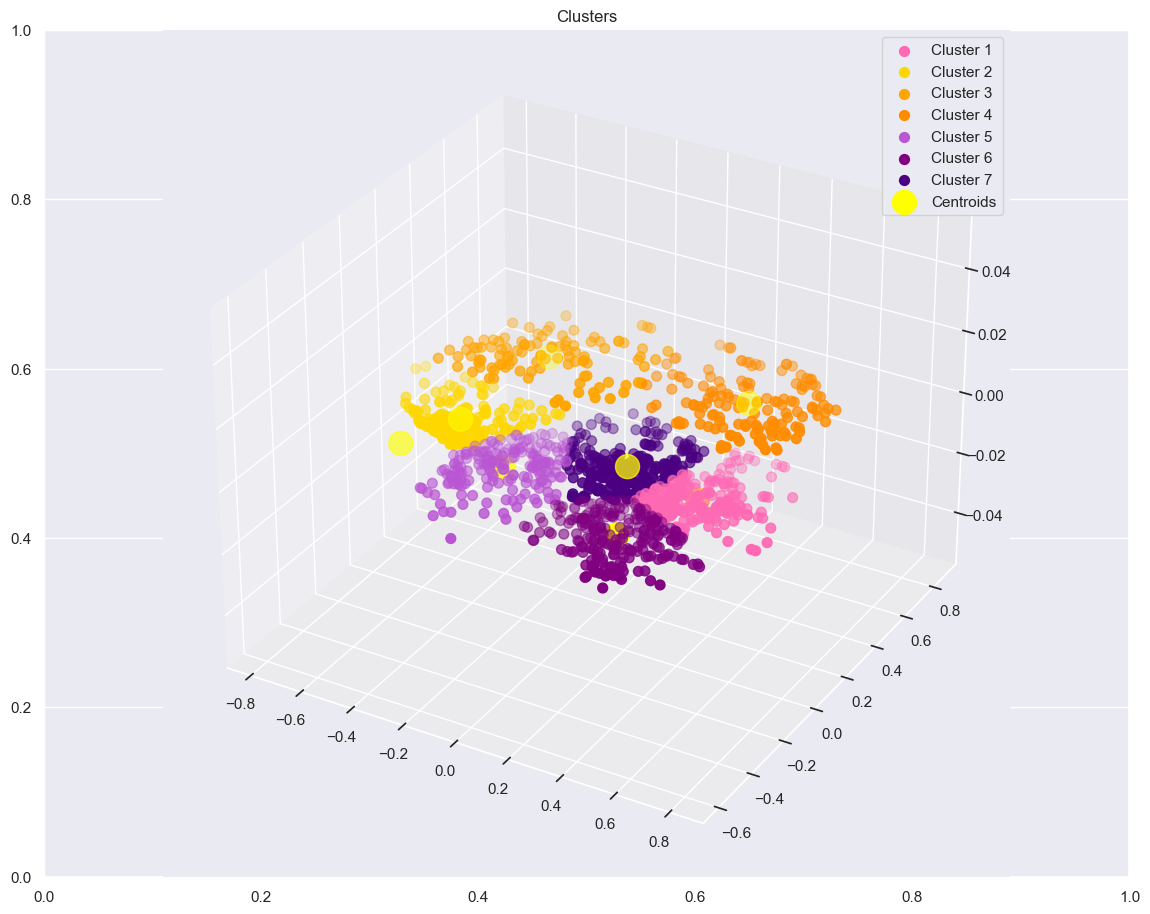

In [222]:
plot_cluster_3d(model_pca_arr,kmeans,y_kmeans,8)

In [223]:
def plot_cluster_2d(df,model):
    # visualize clusters on principle components
    plt.title('K-Means Clustering Results w/ K=2')
    plt.scatter(df[:,0], df[:,1], s=40, c=model.labels_, cmap=plt.cm.prism)
    plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker='*', s=400, c='k', linewidth=2)
    
    save_plots('Cluster 2d')
    plt.gcf().set_size_inches(18.5, 10.5)

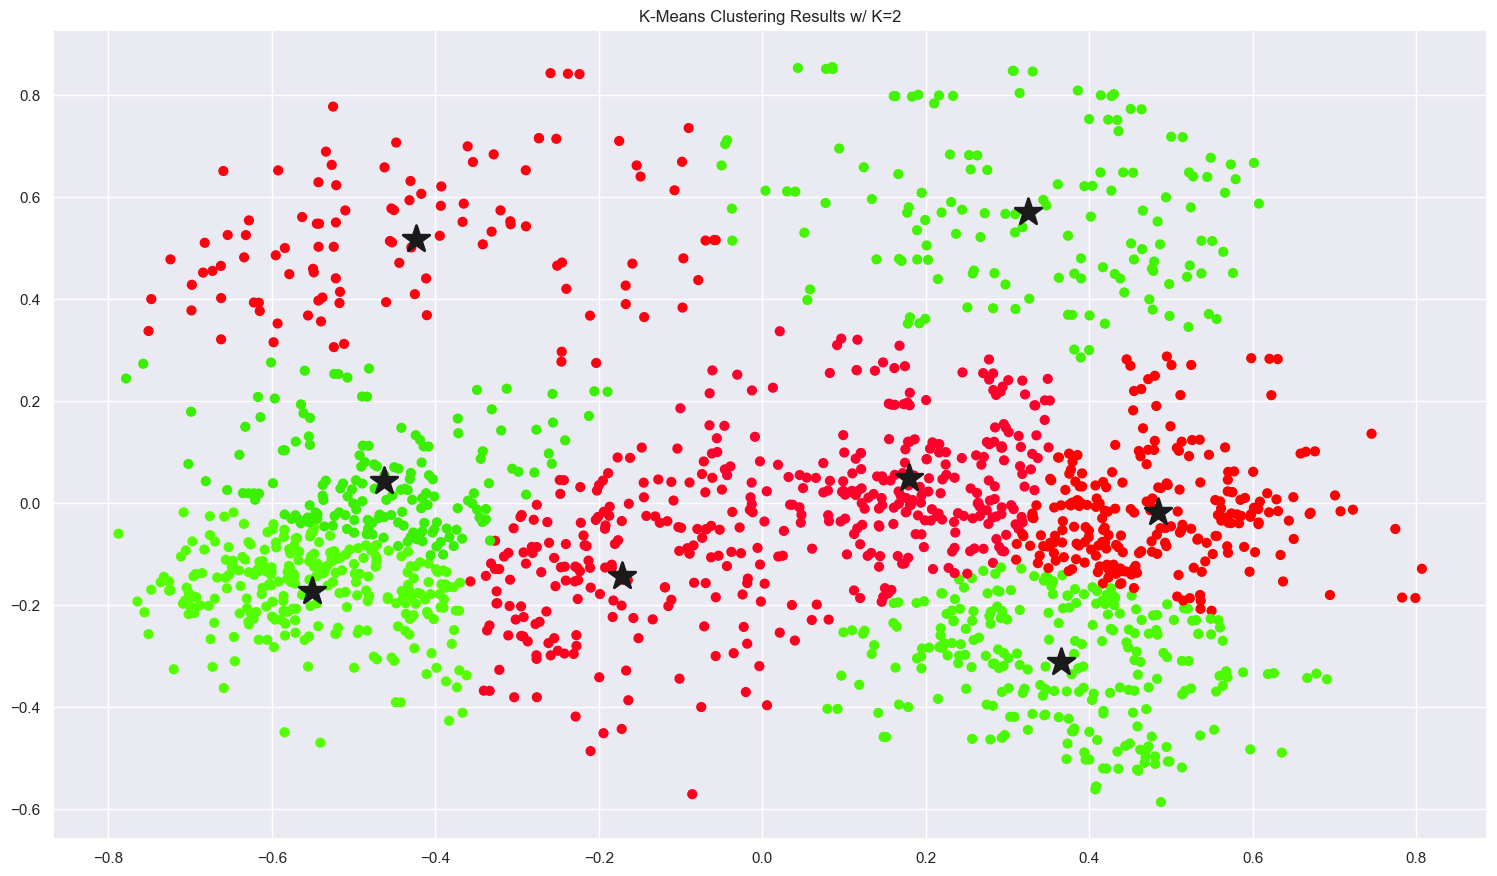

In [224]:
plot_cluster_2d(model_pca_arr,kmeans)

In [225]:
pkl.dump(kmeans,open(PKL_PATH+'/model.pkl','wb'))
with open(PKL_PATH+'/model.pkl','wb') as file:
    pkl.dump(kmeans,file)

<span style="font-size:20px;font-style:bold;background-color:orange;box-shadow:2px 2px 2px black">Define each cluster based on the features.</span>

In [226]:
song_dat_cluster=song_dat.copy()

In [227]:
song_dat_cluster['cluster']=y_kmeans

In [228]:
song_dat_cluster.to_csv(CSV_PATH+'/song data with cluster.csv')

In [229]:
song_dat_cluster.head()

name               album release_date  track_number  \
0   Concert Intro Music - Live  Licked Live In NYC   2022-06-10             1   
1   Street Fighting Man - Live  Licked Live In NYC   2022-06-10             2   
2           Start Me Up - Live  Licked Live In NYC   2022-06-10             3   
3  If You Can't Rock Me - Live  Licked Live In NYC   2022-06-10             4   
4          Donâ€™t Stop - Live  Licked Live In NYC   2022-06-10             5   

                       id                                   uri  acousticness  \
0  2IEkywLJ4ykbhi1yRQvmsT  spotify:track:2IEkywLJ4ykbhi1yRQvmsT        0.0824   
1  6GVgVJBKkGJoRfarYRvGTU  spotify:track:6GVgVJBKkGJoRfarYRvGTU        0.4370   
2  1Lu761pZ0dBTGpzxaQoZNW  spotify:track:1Lu761pZ0dBTGpzxaQoZNW        0.4160   
3  1agTQzOTUnGNggyckEqiDH  spotify:track:1agTQzOTUnGNggyckEqiDH        0.5670   
4  7piGJR8YndQBQWVXv6KtQw  spotify:track:7piGJR8YndQBQWVXv6KtQw        0.4000   

   danceability  energy  instrumentalness  liveness  loudness  speechiness  \
0         0.463   0.993          0.996000     0.932   -12.913       0.1100   
1         0.326   0.965          0.233000     0.961    -4.803       0.0759   
2         0.386   0.969          0.400000     0.956    -4.936       0.1150   
3         0.369   0.985          0.000107     0.895    -5.535       0.1930   
4         0.303   0.969          0.055900     0.966    -5.098       0.0930   

     tempo  valence  popularity  duration_ms  cluster  
0  118.001   0.0302          33        48640        2  
1  131.455   0.3180          34       253173        1  
2  130.066   0.3130          34       263160        1  
3  132.994   0.1470          32       305880        7  
4  130.533   0.2060          32       305106        7

In [230]:
px.scatter_3d(song_dat_cluster,x='danceability',y='energy',z='tempo',color='cluster')

In [231]:
# popularity mean by cluster
song_dat_cluster.groupby(['cluster']).popularity.mean().sort_values(ascending=False)

cluster
5    24.555118
0    23.194215
6    22.701613
3    21.774648
2    19.093458
4    18.194595
1    17.742331
7    17.085502
Name: popularity, dtype: float64

In [232]:
# checking number of songs in each cluster
song_dat_cluster['cluster'].value_counts()

7    269
5    254
6    248
0    242
4    185
1    163
3    142
2    107
Name: cluster, dtype: int64

In [233]:
# Checking which cluster was most popular
song_dat_cluster.groupby('cluster')['popularity'].mean().sort_values(ascending=False)

cluster
5    24.555118
0    23.194215
6    22.701613
3    21.774648
2    19.093458
4    18.194595
1    17.742331
7    17.085502
Name: popularity, dtype: float64

In [234]:
# Checking the song for cluster 5 as it has the highly most popular song
song_dat_cluster.loc[song_dat_cluster['cluster'] == 5][:10].head()

name                      album  \
52  Worried About You - Remastered 2021  Tattoo You (Super Deluxe)   
54             Heaven - Remastered 2021  Tattoo You (Super Deluxe)   
55   No Use In Crying - Remastered 2021  Tattoo You (Super Deluxe)   
61                           Drift Away  Tattoo You (Super Deluxe)   
64           Fast Talking, Slow Walking  Tattoo You (Super Deluxe)   

   release_date  track_number                      id  \
52   2021-10-22             7  0Vb7dqiZ89IQngeX52jLaO   
54   2021-10-22             9  7f1HoWerlIfVpwgsOu0Mib   
55   2021-10-22            10  4hH58AvAjRwnWQnC5IXhzR   
61   2021-10-22             5  100ccVerC10XT80e9qKcNb   
64   2021-10-22             8  1a4BmdKkz56SERLEoWJNc8   

                                     uri  acousticness  danceability  energy  \
52  spotify:track:0Vb7dqiZ89IQngeX52jLaO        0.0804         0.423   0.714   
54  spotify:track:7f1HoWerlIfVpwgsOu0Mib        0.1740         0.611   0.559   
55  spotify:track:4hH58AvAjRwnWQnC5IXhzR        0.5780         0.594   0.609   
61  spotify:track:100ccVerC10XT80e9qKcNb        0.0971         0.421   0.674   
64  spotify:track:1a4BmdKkz56SERLEoWJNc8        0.4290         0.436   0.724   

    instrumentalness  liveness  loudness  speechiness    tempo  valence  \
52          0.000517    0.0820    -4.010       0.0318   84.351    0.383   
54          0.016700    0.1320    -5.833       0.0325  114.128    0.111   
55          0.000337    0.2290    -3.171       0.0311  142.838    0.404   
61          0.000010    0.1180    -3.404       0.0589   78.519    0.603   
64          0.002740    0.0523    -2.890       0.0313   73.698    0.277   

    popularity  duration_ms  cluster  
52          26       318253        5  
54          31       263186        5  
55          25       206533        5  
61          31       246586        5  
64          22       340200        5

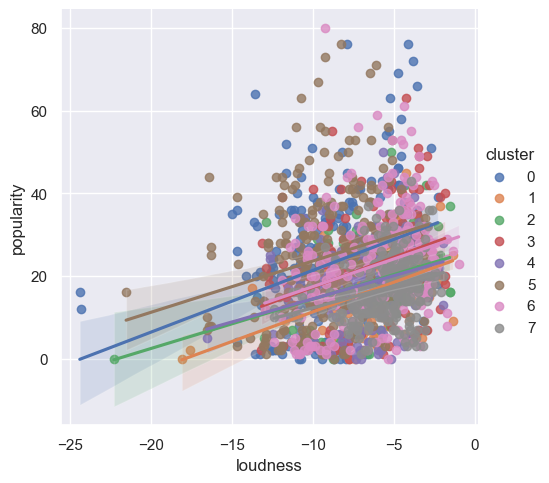

In [235]:
# Showing how loudliness affect the popularity
sns.lmplot(data=song_dat_cluster,x='loudness',y='popularity',hue='cluster');
save_plots('Loudness popularity')
plt.show()

In [236]:
song_dat_cluster.iloc[:,6:].columns

Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'popularity',
       'duration_ms', 'cluster'],
      dtype='object')

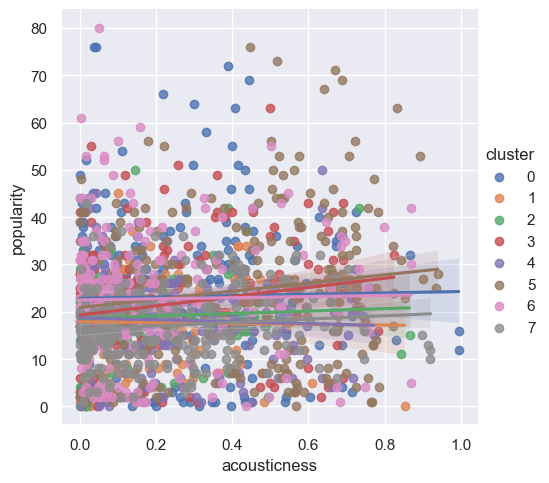

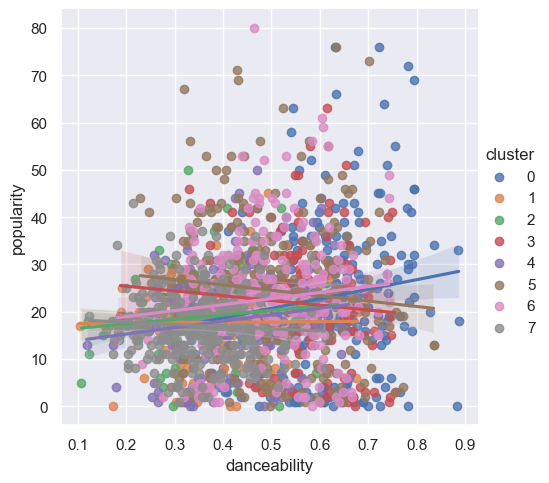

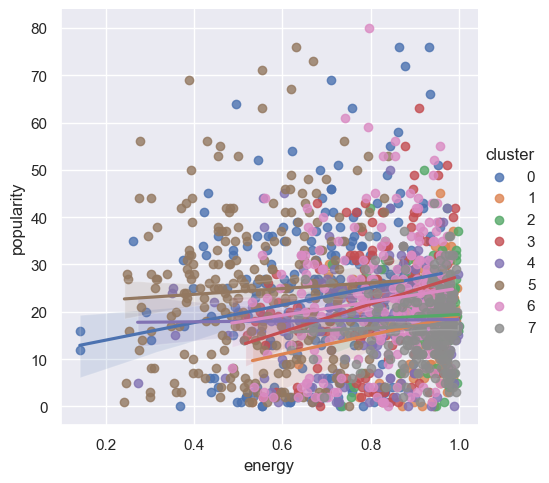

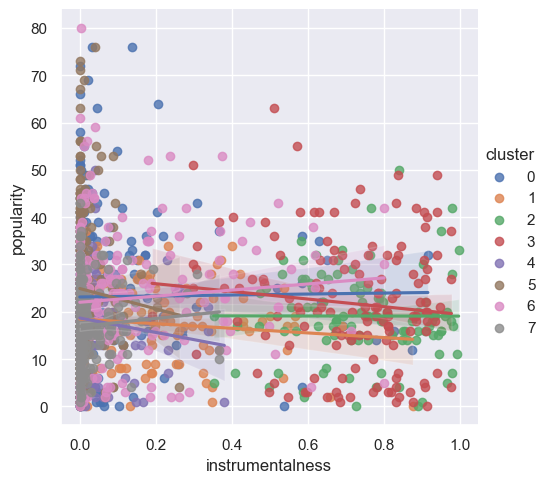

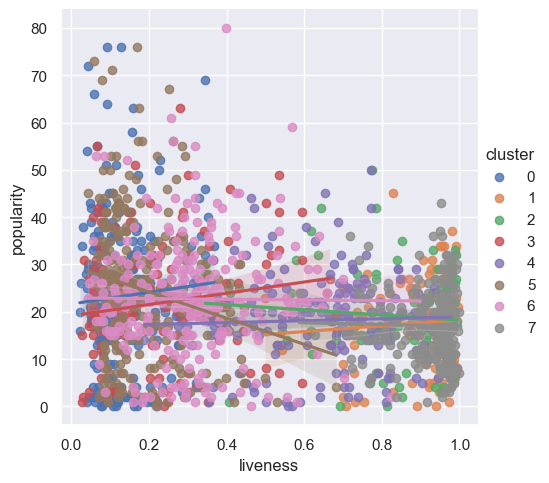

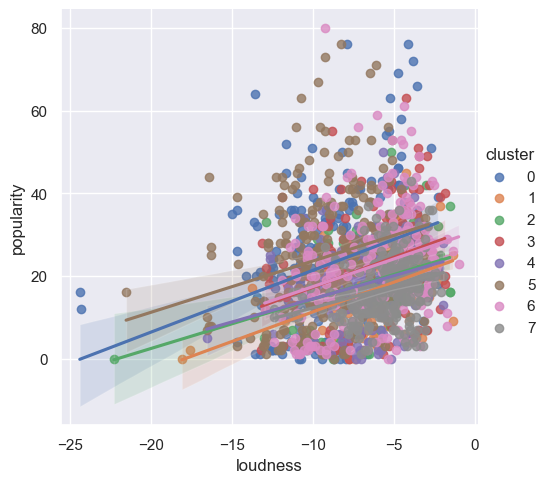

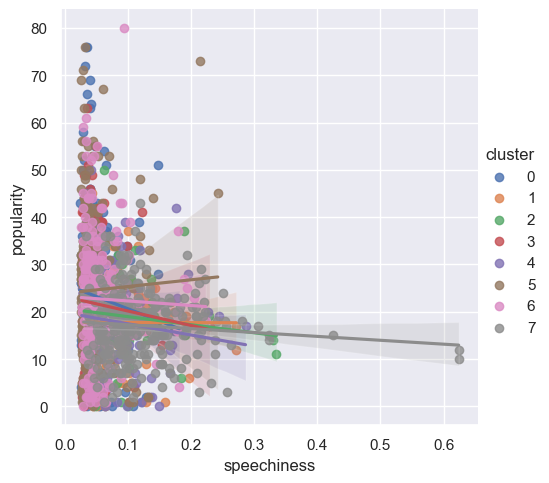

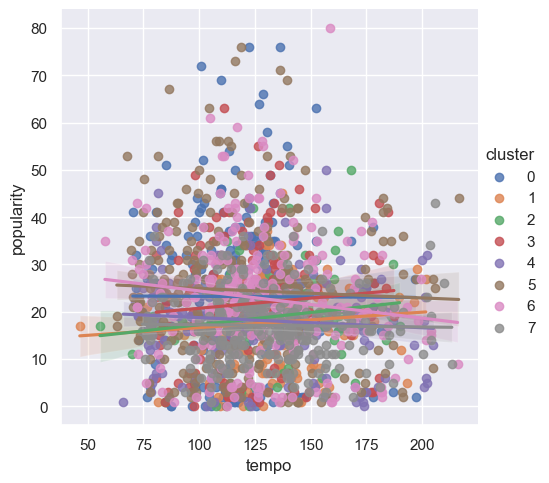

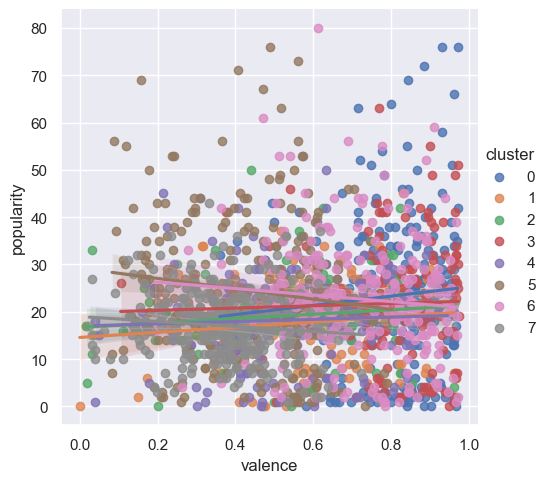

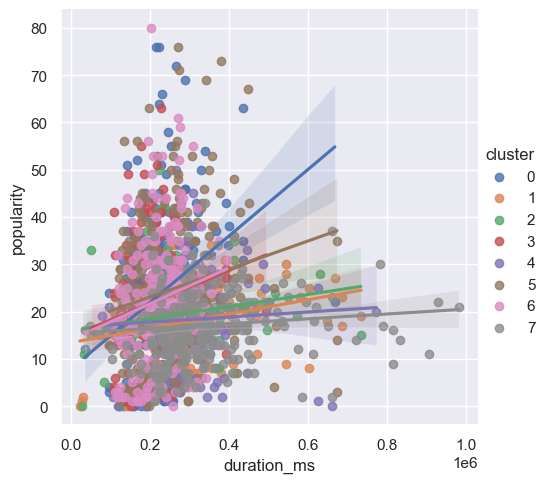

<Figure size 640x480 with 0 Axes>

In [237]:
for col in ['acousticness', 'danceability', 'energy', 'instrumentalness','liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_ms']:
    sns.lmplot(data=song_dat_cluster,x=col,y='popularity',hue='cluster');
    save_plots(f'Lmplots {col} vs popularity')
    plt.show()
plt.tight_layout()

<span style="font-size:15px;font-weight:bold;color:#fbbf24">Finding:</span>
- The song belong to the cluster 5 was the most popular song 
- For each cluster there is around 200 songs

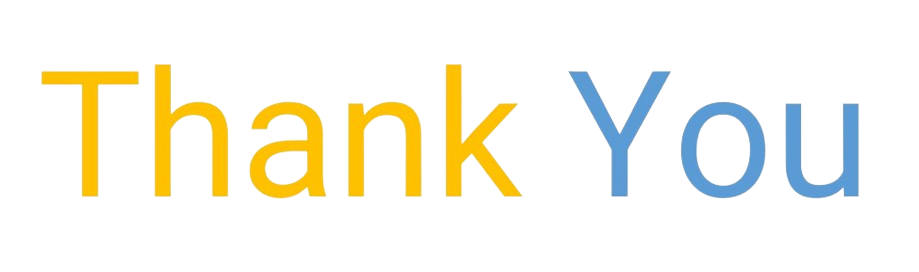